# Credit Card Fraud Detection
## Complete Machine Learning Pipeline with Comprehensive EDA



<a id='1-setup'></a>
## 1. Setup and Data Loading

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import time

# Statistical tests
from scipy import stats
from scipy.stats import ks_2samp, mannwhitneyu, chi2_contingency, spearmanr, pearsonr

# Sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.cluster import KMeans
from sklearn.metrics import (
    average_precision_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, precision_recall_curve, roc_curve
)

# XGBoost
from xgboost import XGBClassifier

# TensorFlow for Autoencoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Configuration
warnings.filterwarnings('ignore')
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

# Display settings
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', '{:.4f}'.format)

# Plot settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 10

# Color palette for fraud/normal
COLORS = {'normal': '#2ecc71', 'fraud': '#e74c3c'}
CLASS_PALETTE = {0: COLORS['normal'], 1: COLORS['fraud']}

print("Environment configured successfully")
print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"TensorFlow: {tf.__version__}")

Environment configured successfully
NumPy: 2.3.3
Pandas: 2.3.2
TensorFlow: 2.20.0


In [2]:
# Load dataset
DATA_PATH = Path('creditcard.csv')

alternative_paths = [
    Path('data/creditcard.csv'),
    Path('data/raw/creditcard.csv'),
    Path('../data/creditcard.csv'),
    Path('D:/Downloads/archive (1)/creditcard.csv'),
]

for p in [DATA_PATH] + alternative_paths:
    if p.exists():
        DATA_PATH = p
        break

print(f"Loading data from: {DATA_PATH}")
df = pd.read_csv(DATA_PATH)
print(f"Dataset loaded: {df.shape[0]:,} rows x {df.shape[1]} columns")

Loading data from: D:\Downloads\archive (1)\creditcard.csv
Dataset loaded: 284,807 rows x 31 columns


---

<a id='2-eda'></a>
## 2. Exploratory Data Analysis (EDA)

A thorough EDA is essential to:
- Understand data quality and structure
- Identify patterns that distinguish fraud from legitimate transactions
- Guide feature engineering decisions
- Inform model selection and hyperparameter choices

### 2.1 Data Overview and Quality Assessment

In [3]:
print("="*70)
print("DATA OVERVIEW")
print("="*70)

print(f"\nShape: {df.shape[0]:,} transactions x {df.shape[1]} features")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\nColumn Types:")
print(df.dtypes.value_counts())

print("\nFirst 5 rows:")
df.head()

DATA OVERVIEW

Shape: 284,807 transactions x 31 features
Memory usage: 67.36 MB

Column Types:
float64    30
int64       1
Name: count, dtype: int64

First 5 rows:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0000,-1.3598,-0.0728,2.5363,1.3782,-0.3383,0.4624,0.2396,0.0987,0.3638,0.0908,-0.5516,-0.6178,-0.9914,-0.3112,1.4682,-0.4704,0.2080,0.0258,0.4040,0.2514,-0.0183,0.2778,-0.1105,0.0669,0.1285,-0.1891,0.1336,-0.0211,149.6200,0
1,0.0000,1.1919,0.2662,0.1665,0.4482,0.0600,-0.0824,-0.0788,0.0851,-0.2554,-0.1670,1.6127,1.0652,0.4891,-0.1438,0.6356,0.4639,-0.1148,-0.1834,-0.1458,-0.0691,-0.2258,-0.6387,0.1013,-0.3398,0.1672,0.1259,-0.0090,0.0147,2.6900,0
2,1.0000,-1.3584,-1.3402,1.7732,0.3798,-0.5032,1.8005,0.7915,0.2477,-1.5147,0.2076,0.6245,0.0661,0.7173,-0.1659,2.3459,-2.8901,1.1100,-0.1214,-2.2619,0.5250,0.2480,0.7717,0.9094,-0.6893,-0.3276,-0.1391,-0.0554,-0.0598,378.6600,0
3,1.0000,-0.9663,-0.1852,1.7930,-0.8633,-0.0103,1.2472,0.2376,0.3774,-1.3870,-0.0550,-0.2265,0.1782,0.5078,-0.2879,-0.6314,-1.0596,-0.6841,1.9658,-1.2326,-0.2080,-0.1083,0.0053,-0.1903,-1.1756,0.6474,-0.2219,0.0627,0.0615,123.5000,0
4,2.0000,-1.1582,0.8777,1.5487,0.4030,-0.4072,0.0959,0.5929,-0.2705,0.8177,0.7531,-0.8228,0.5382,1.3459,-1.1197,0.1751,-0.4514,-0.2370,-0.0382,0.8035,0.4085,-0.0094,0.7983,-0.1375,0.1413,-0.2060,0.5023,0.2194,0.2152,69.9900,0


In [4]:
# Data quality check
print("="*70)
print("DATA QUALITY ASSESSMENT")
print("="*70)

# Missing values
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100

print(f"\nMissing Values: {missing.sum()} total")
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print("  No missing values found")

# Duplicates
n_duplicates = df.duplicated().sum()
print(f"\nDuplicate Rows: {n_duplicates:,} ({n_duplicates/len(df)*100:.4f}%)")

# Infinite values
inf_count = np.isinf(df.select_dtypes(include=[np.number])).sum().sum()
print(f"Infinite Values: {inf_count}")

# Data types summary
print("\nNumeric Features Summary:")
print(f"  Total features: {len(df.columns)}")
print(f"  Numeric: {len(df.select_dtypes(include=[np.number]).columns)}")
print(f"  Categorical: {len(df.select_dtypes(include=['object', 'category']).columns)}")

DATA QUALITY ASSESSMENT

Missing Values: 0 total
  No missing values found

Duplicate Rows: 1,081 (0.3796%)
Infinite Values: 0

Numeric Features Summary:
  Total features: 31
  Numeric: 31
  Categorical: 0


In [5]:
# Statistical summary
print("="*70)
print("STATISTICAL SUMMARY")
print("="*70)

desc_stats = df.describe().T
desc_stats['skewness'] = df.skew()
desc_stats['kurtosis'] = df.kurtosis()
desc_stats['iqr'] = desc_stats['75%'] - desc_stats['25%']

print("\nKey Statistics:")
desc_stats[['mean', 'std', 'min', 'max', 'skewness', 'kurtosis']].round(4)

STATISTICAL SUMMARY

Key Statistics:


,mean,std,min,max,skewness,kurtosis
Time,94813.8596,47488.1460,0.0000,172792.0000,-0.0356,-1.2935
V1,0.0000,1.9587,-56.4075,2.4549,-3.2807,32.4867
V2,0.0000,1.6513,-72.7157,22.0577,-4.6249,95.7731
V3,-0.0000,1.5163,-48.3256,9.3826,-2.2402,26.6196
V4,0.0000,1.4159,-5.6832,16.8753,0.6763,2.6355
V5,0.0000,1.3802,-113.7433,34.8017,-2.4259,206.9046
V6,0.0000,1.3323,-26.1605,73.3016,1.8266,42.6425
V7,-0.0000,1.2371,-43.5572,120.5895,2.5539,405.6074
V8,0.0000,1.1944,-73.2167,20.0072,-8.5219,220.5870
V9,-0.0000,1.0986,-13.4341,15.5950,0.5547,3.7313


### 2.2 Target Variable Analysis (Class Imbalance)

In [6]:
print("="*70)
print("TARGET VARIABLE ANALYSIS")
print("="*70)

# Class distribution
class_counts = df['Class'].value_counts()
class_pct = df['Class'].value_counts(normalize=True) * 100

n_normal = class_counts[0]
n_fraud = class_counts[1]
imbalance_ratio = n_normal / n_fraud

print(f"\nClass Distribution:")
print(f"  Normal (0):  {n_normal:,} transactions ({class_pct[0]:.4f}%)")
print(f"  Fraud (1):   {n_fraud:,} transactions ({class_pct[1]:.4f}%)")
print(f"\nImbalance Ratio: {imbalance_ratio:.0f}:1")
print(f"Fraud Rate: {n_fraud/len(df)*100:.4f}%")

TARGET VARIABLE ANALYSIS

Class Distribution:
  Normal (0):  284,315 transactions (99.8273%)
  Fraud (1):   492 transactions (0.1727%)

Imbalance Ratio: 578:1
Fraud Rate: 0.1727%


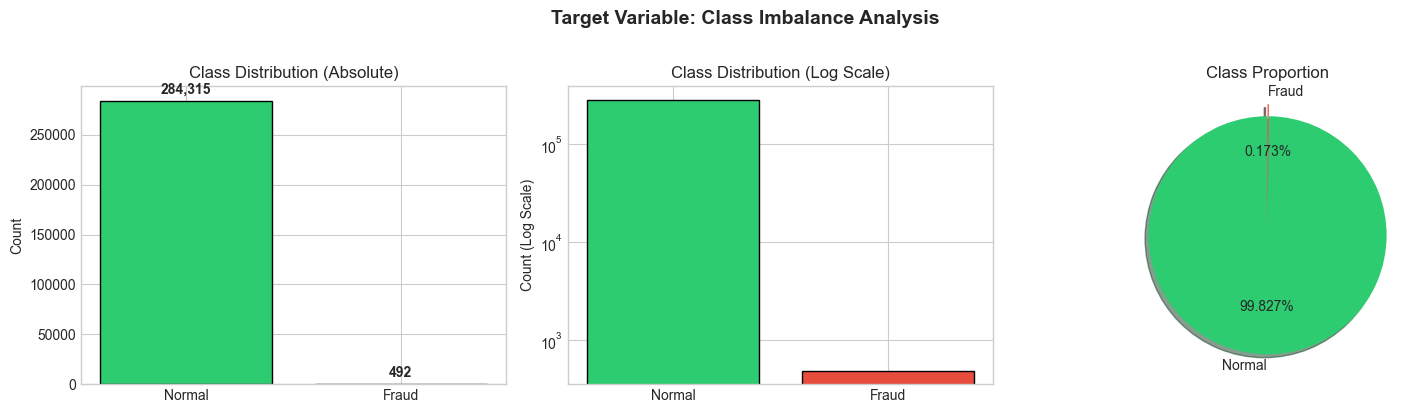


Insight: Extreme class imbalance (577:1) requires:
  - Appropriate evaluation metrics (Average Precision, not Accuracy)
  - Class balancing techniques (SMOTE, class weights)
  - Anomaly detection approaches (Isolation Forest, Autoencoder)


In [7]:
# Visualize class distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Bar plot
bars = axes[0].bar(['Normal', 'Fraud'], [n_normal, n_fraud], 
                   color=[COLORS['normal'], COLORS['fraud']], edgecolor='black')
axes[0].set_ylabel('Count')
axes[0].set_title('Class Distribution (Absolute)')
for bar, count in zip(bars, [n_normal, n_fraud]):
    axes[0].annotate(f'{count:,}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                     xytext=(0, 5), textcoords='offset points', ha='center', fontweight='bold')

# Log scale bar plot
bars = axes[1].bar(['Normal', 'Fraud'], [n_normal, n_fraud],
                   color=[COLORS['normal'], COLORS['fraud']], edgecolor='black')
axes[1].set_ylabel('Count (Log Scale)')
axes[1].set_title('Class Distribution (Log Scale)')
axes[1].set_yscale('log')

# Pie chart
axes[2].pie([n_normal, n_fraud], labels=['Normal', 'Fraud'], autopct='%1.3f%%',
            colors=[COLORS['normal'], COLORS['fraud']], explode=[0, 0.1],
            shadow=True, startangle=90)
axes[2].set_title('Class Proportion')

plt.suptitle('Target Variable: Class Imbalance Analysis', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\nInsight: Extreme class imbalance (577:1) requires:")
print("  - Appropriate evaluation metrics (Average Precision, not Accuracy)")
print("  - Class balancing techniques (SMOTE, class weights)")
print("  - Anomaly detection approaches (Isolation Forest, Autoencoder)")

### 2.3 Univariate Analysis

In [8]:
print("="*70)
print("UNIVARIATE ANALYSIS")
print("="*70)

UNIVARIATE ANALYSIS


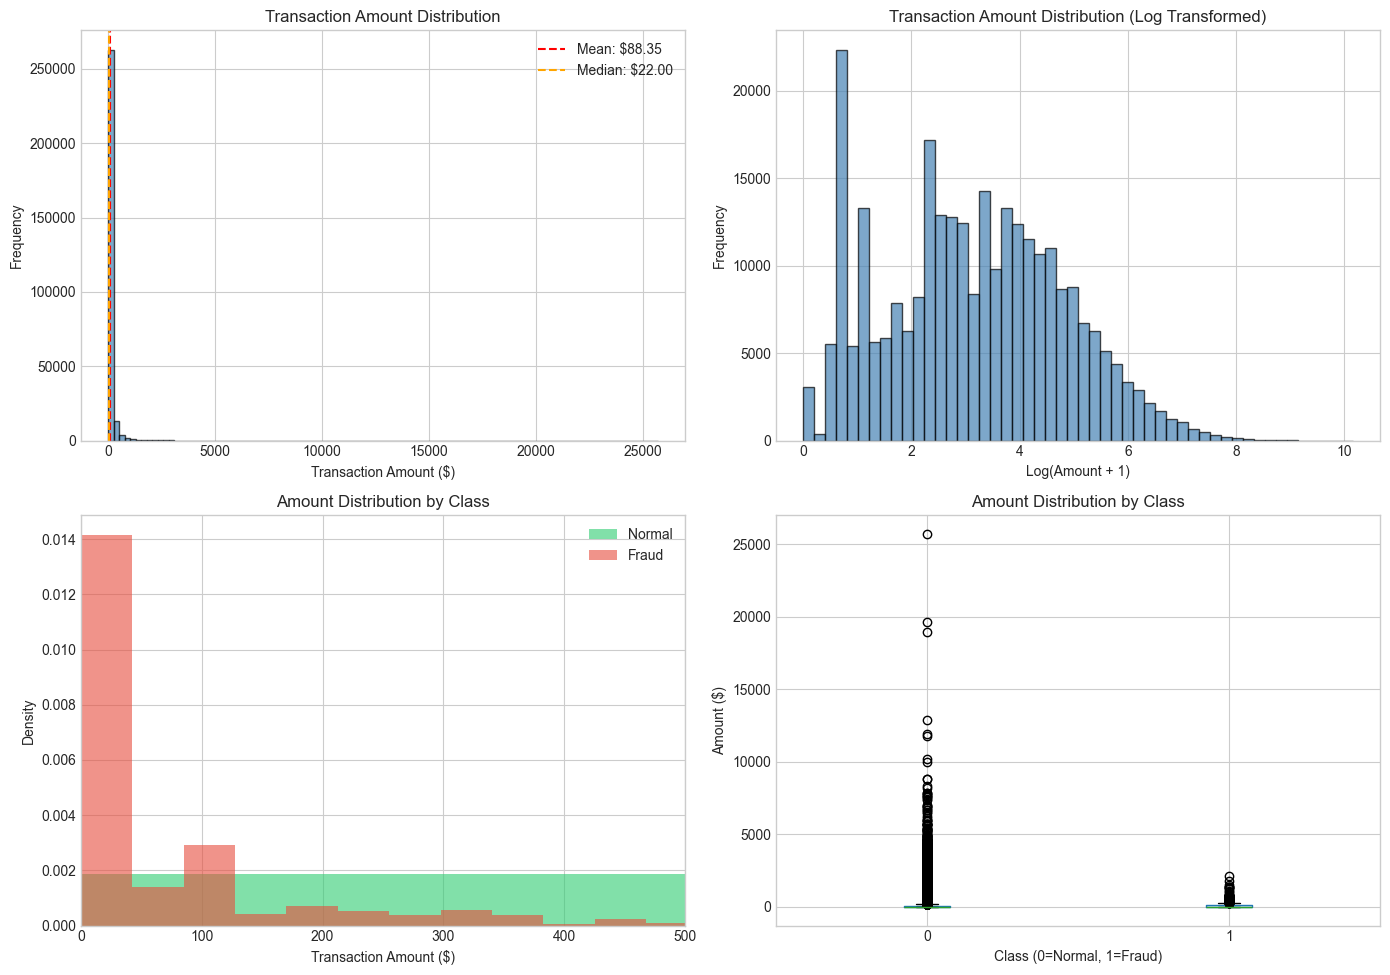


Amount Statistics by Class:
            count     mean      std    min    25%     50%      75%        max
Class                                                                        
0     284315.0000  88.2900 250.1100 0.0000 5.6500 22.0000  77.0500 25691.1600
1        492.0000 122.2100 256.6800 0.0000 1.0000  9.2500 105.8900  2125.8700


In [9]:
# Amount distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Overall Amount distribution
axes[0, 0].hist(df['Amount'], bins=100, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(df['Amount'].mean(), color='red', linestyle='--', label=f"Mean: ${df['Amount'].mean():.2f}")
axes[0, 0].axvline(df['Amount'].median(), color='orange', linestyle='--', label=f"Median: ${df['Amount'].median():.2f}")
axes[0, 0].set_xlabel('Transaction Amount ($)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Transaction Amount Distribution')
axes[0, 0].legend()

# Amount distribution (log scale)
axes[0, 1].hist(np.log1p(df['Amount']), bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Log(Amount + 1)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Transaction Amount Distribution (Log Transformed)')

# Amount by class
df_normal = df[df['Class'] == 0]
df_fraud = df[df['Class'] == 1]

axes[1, 0].hist(df_normal['Amount'], bins=50, color=COLORS['normal'], alpha=0.6, label='Normal', density=True)
axes[1, 0].hist(df_fraud['Amount'], bins=50, color=COLORS['fraud'], alpha=0.6, label='Fraud', density=True)
axes[1, 0].set_xlabel('Transaction Amount ($)')
axes[1, 0].set_ylabel('Density')
axes[1, 0].set_title('Amount Distribution by Class')
axes[1, 0].legend()
axes[1, 0].set_xlim(0, 500)  # Focus on main range

# Box plot by class
df.boxplot(column='Amount', by='Class', ax=axes[1, 1])
axes[1, 1].set_xlabel('Class (0=Normal, 1=Fraud)')
axes[1, 1].set_ylabel('Amount ($)')
axes[1, 1].set_title('Amount Distribution by Class')
plt.suptitle('')

plt.tight_layout()
plt.show()

# Statistics
print("\nAmount Statistics by Class:")
print(df.groupby('Class')['Amount'].describe().round(2))

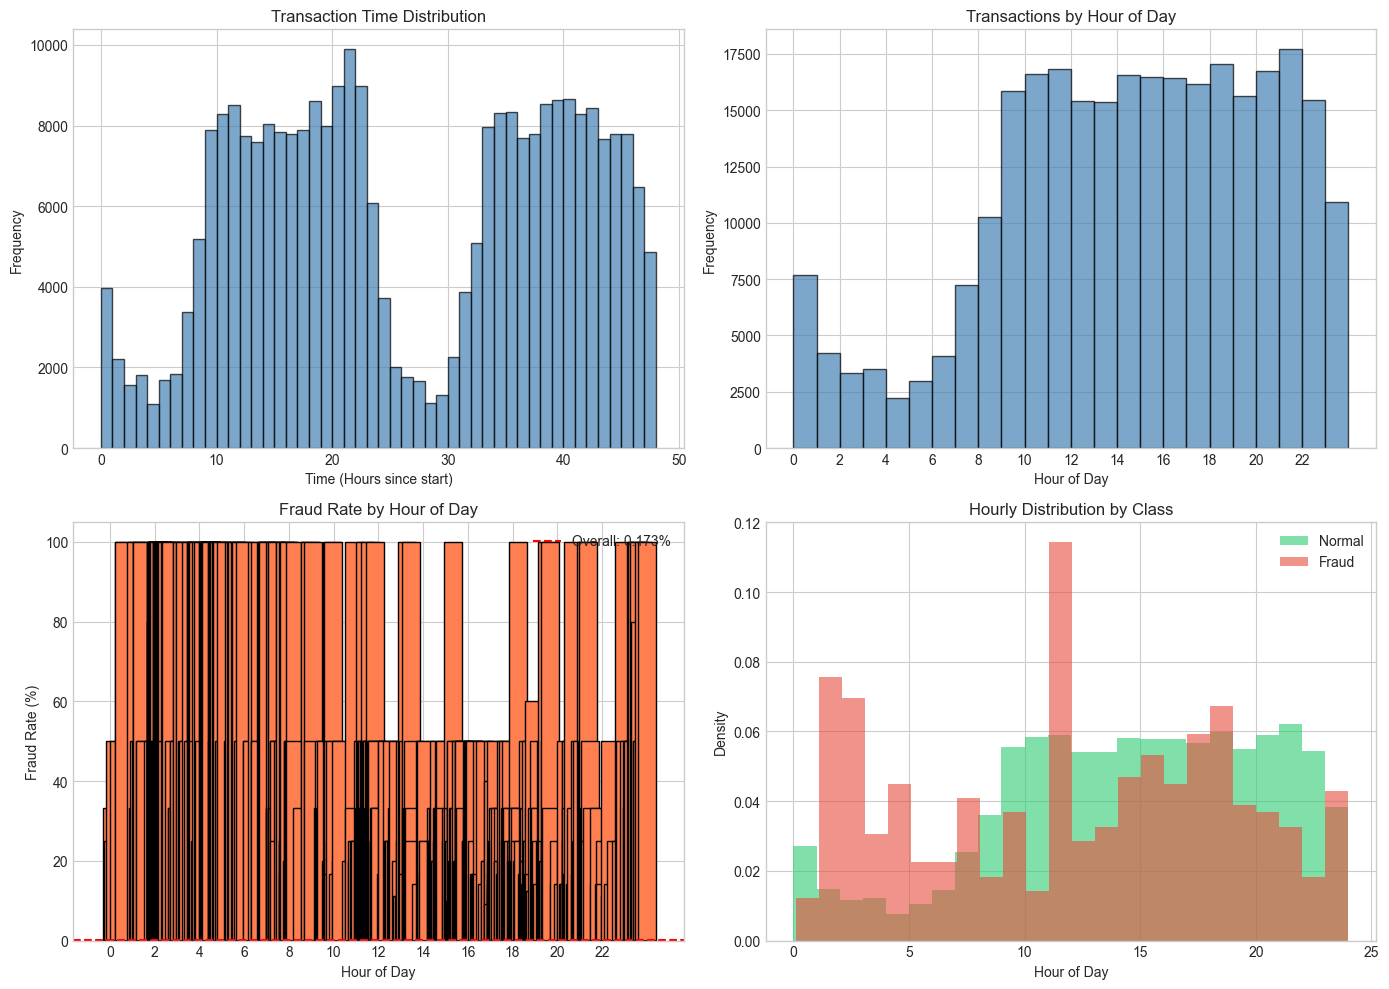


Insight: Fraud patterns may vary by time of day (feature engineering opportunity)


In [10]:
# Time distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Convert time to hours
df['Hour'] = (df['Time'] / 3600) % 24
df['Day'] = df['Time'] // (24 * 3600)

# Overall time distribution
axes[0, 0].hist(df['Time'] / 3600, bins=48, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Time (Hours since start)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Transaction Time Distribution')

# Hourly distribution
axes[0, 1].hist(df['Hour'], bins=24, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Hour of Day')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Transactions by Hour of Day')
axes[0, 1].set_xticks(range(0, 24, 2))

# Fraud rate by hour
hourly_fraud = df.groupby('Hour')['Class'].agg(['sum', 'count'])
hourly_fraud['fraud_rate'] = hourly_fraud['sum'] / hourly_fraud['count'] * 100

axes[1, 0].bar(hourly_fraud.index, hourly_fraud['fraud_rate'], color='coral', edgecolor='black')
axes[1, 0].axhline(y=df['Class'].mean()*100, color='red', linestyle='--', label=f"Overall: {df['Class'].mean()*100:.3f}%")
axes[1, 0].set_xlabel('Hour of Day')
axes[1, 0].set_ylabel('Fraud Rate (%)')
axes[1, 0].set_title('Fraud Rate by Hour of Day')
axes[1, 0].legend()
axes[1, 0].set_xticks(range(0, 24, 2))

# Time density by class - update subsets with new Hour column
df_normal = df[df['Class'] == 0]
df_fraud = df[df['Class'] == 1]

axes[1, 1].hist(df_normal['Hour'], bins=24, color=COLORS['normal'], alpha=0.6, label='Normal', density=True)
axes[1, 1].hist(df_fraud['Hour'], bins=24, color=COLORS['fraud'], alpha=0.6, label='Fraud', density=True)
axes[1, 1].set_xlabel('Hour of Day')
axes[1, 1].set_ylabel('Density')
axes[1, 1].set_title('Hourly Distribution by Class')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print("\nInsight: Fraud patterns may vary by time of day (feature engineering opportunity)")

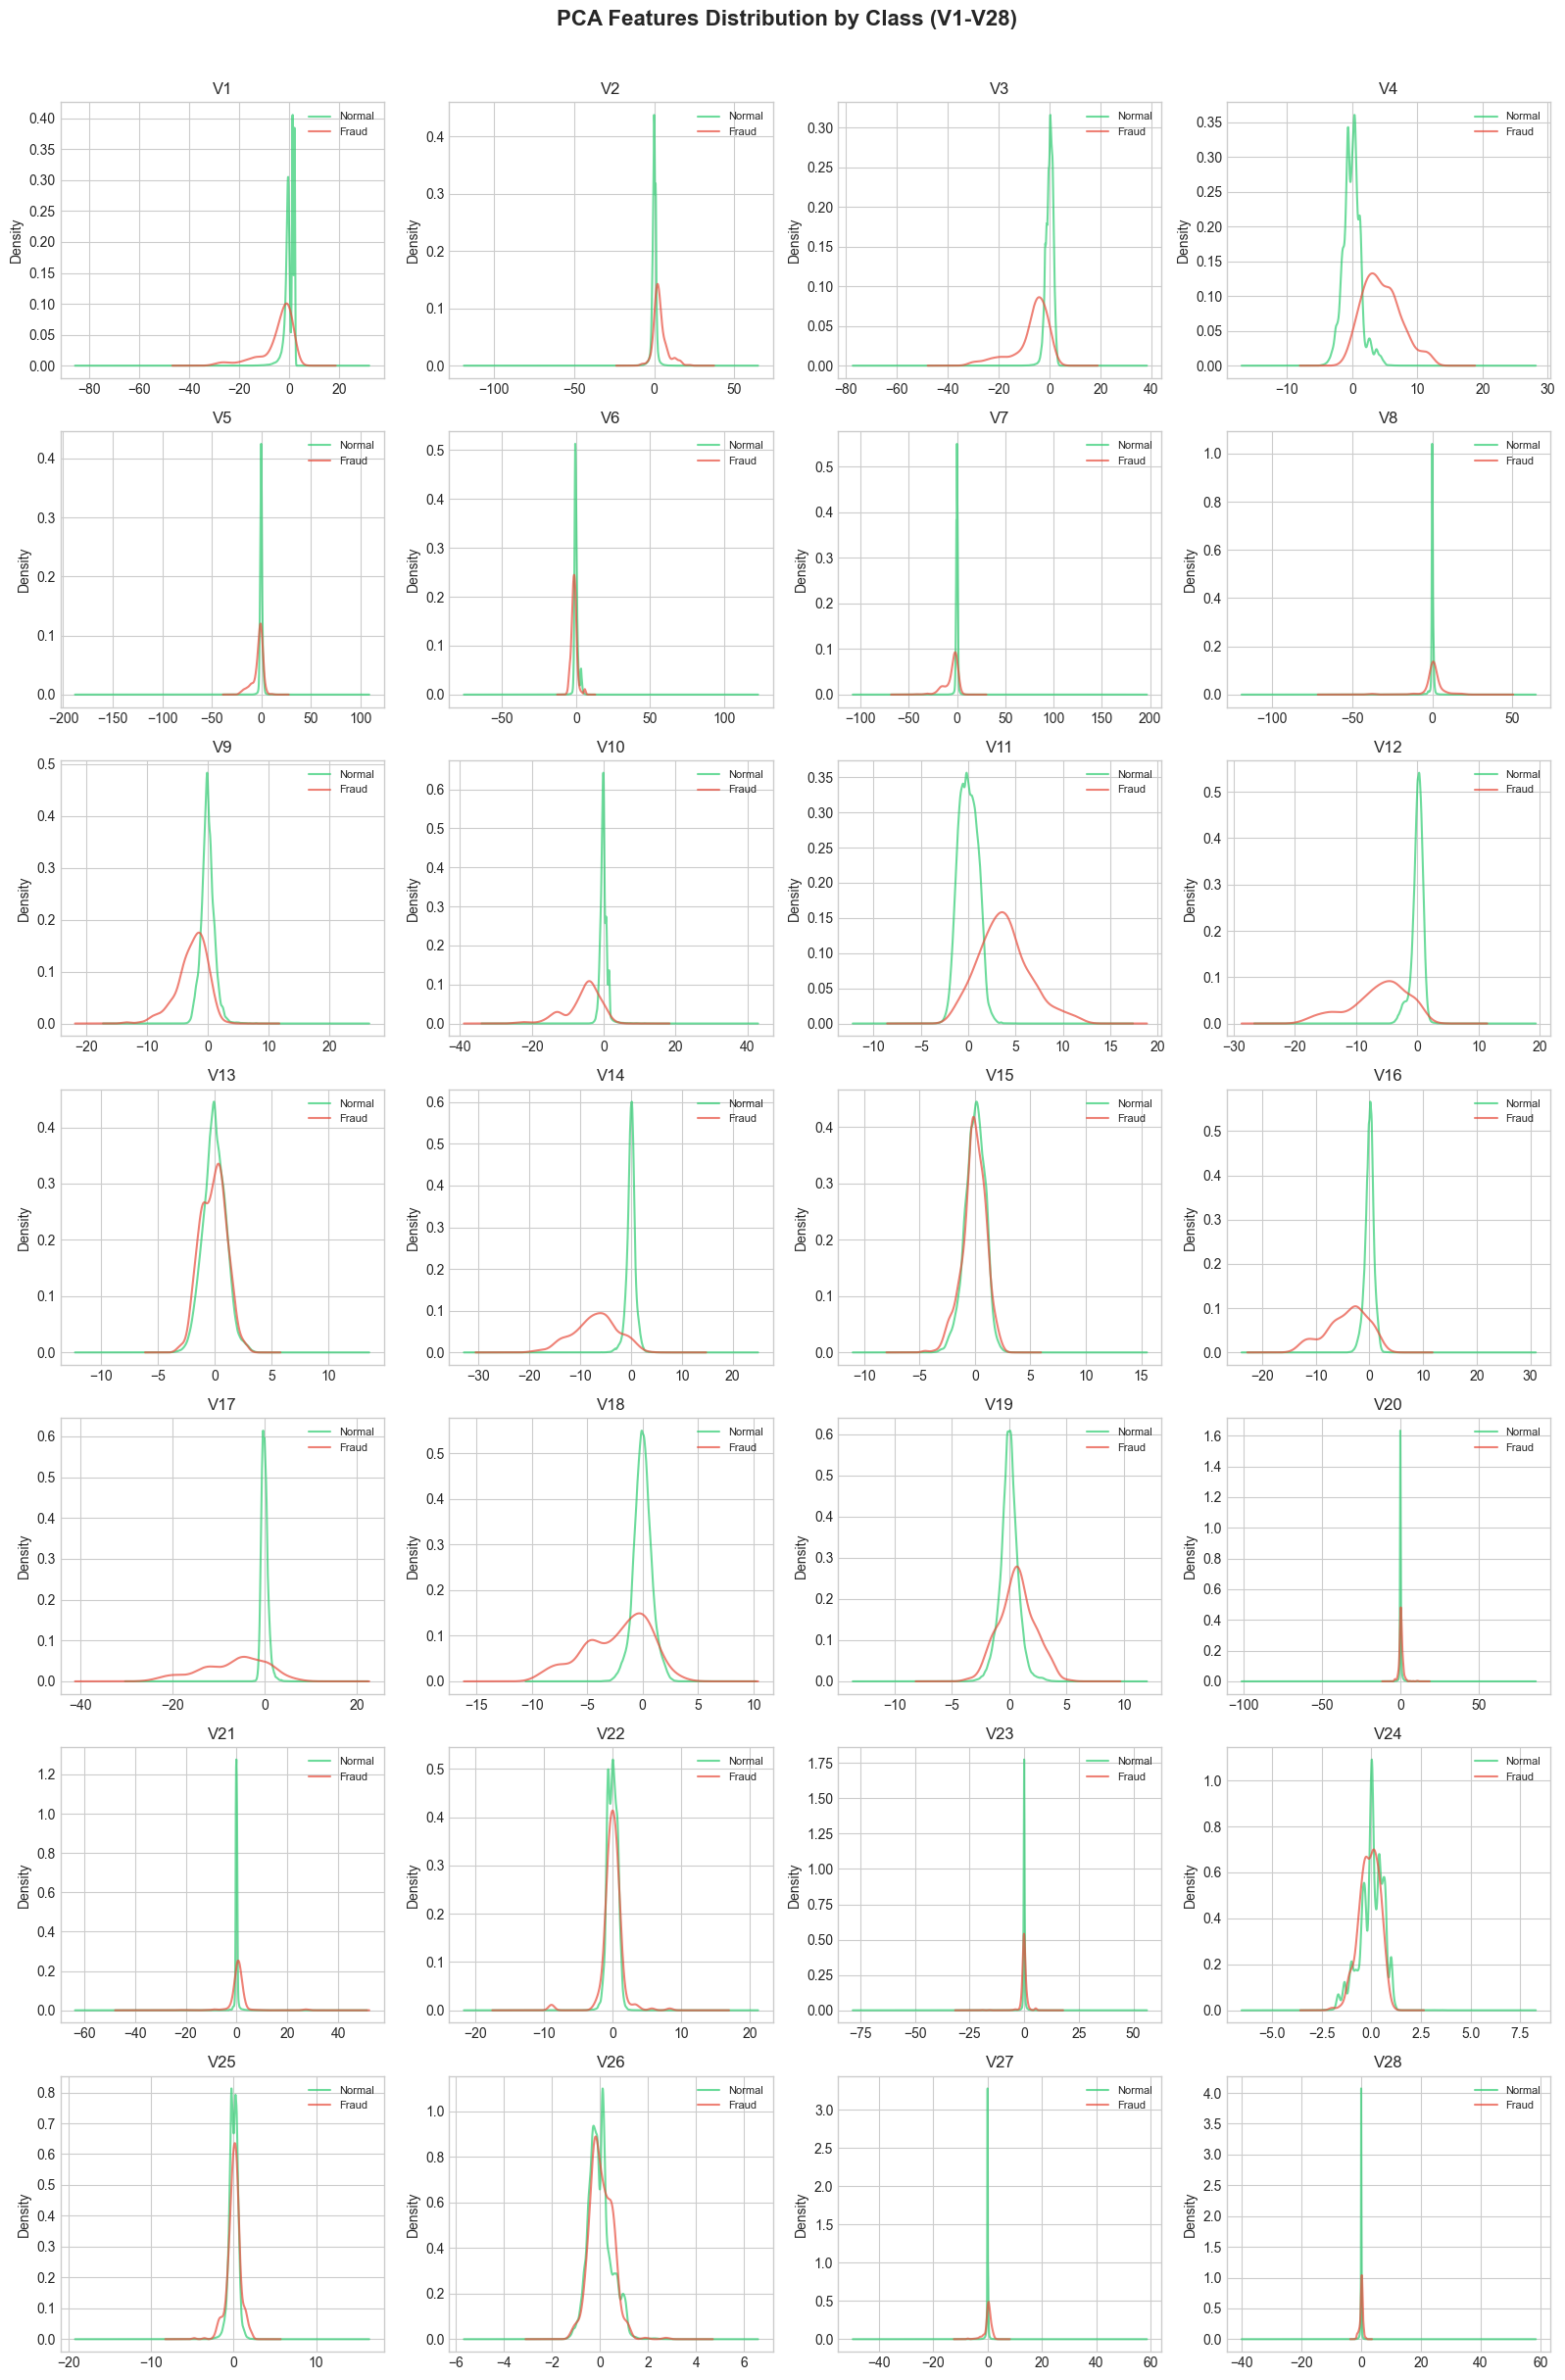


Insight: Features with visibly different distributions between classes
         will have higher discriminative power (e.g., V14, V12, V10, V17)


In [11]:
# PCA features distribution (V1-V28)
pca_features = [f'V{i}' for i in range(1, 29)]

fig, axes = plt.subplots(7, 4, figsize=(16, 24))
axes = axes.flatten()

for idx, col in enumerate(pca_features):
    ax = axes[idx]
    
    # KDE plot by class
    df_normal[col].plot(kind='kde', ax=ax, color=COLORS['normal'], label='Normal', alpha=0.7)
    df_fraud[col].plot(kind='kde', ax=ax, color=COLORS['fraud'], label='Fraud', alpha=0.7)
    
    ax.set_title(f'{col}')
    ax.set_xlabel('')
    ax.legend(fontsize=8)

plt.suptitle('PCA Features Distribution by Class (V1-V28)', fontsize=16, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

print("\nInsight: Features with visibly different distributions between classes")
print("         will have higher discriminative power (e.g., V14, V12, V10, V17)")

### 2.4 Bivariate Analysis (Pairwise Distributions)

In [ ]:
print("="*70)
print("BIVARIATE ANALYSIS - PAIRWISE DISTRIBUTIONS")
print("="*70)

BIVARIATE ANALYSIS - PAIRWISE DISTRIBUTIONS


In [ ]:
# Identify most discriminative features first (for focused pairwise analysis)
def calculate_feature_discrimination(df, target_col='Class'):
    """
    Calculate discrimination power of each feature using multiple metrics.
    """
    results = []
    
    features = [col for col in df.columns if col != target_col]
    
    for col in features:
        normal_vals = df[df[target_col] == 0][col].dropna()
        fraud_vals = df[df[target_col] == 1][col].dropna()
        
        # Mean difference (standardized)
        pooled_std = np.sqrt((normal_vals.std()**2 + fraud_vals.std()**2) / 2)
        cohens_d = abs(fraud_vals.mean() - normal_vals.mean()) / (pooled_std + 1e-8)
        
        # Kolmogorov-Smirnov test
        ks_stat, ks_pval = ks_2samp(normal_vals, fraud_vals)
        
        # Mann-Whitney U test
        try:
            mw_stat, mw_pval = mannwhitneyu(normal_vals, fraud_vals, alternative='two-sided')
        except:
            mw_stat, mw_pval = 0, 1
        
        results.append({
            'feature': col,
            'cohens_d': cohens_d,
            'ks_statistic': ks_stat,
            'ks_pvalue': ks_pval,
            'mw_pvalue': mw_pval,
            'mean_normal': normal_vals.mean(),
            'mean_fraud': fraud_vals.mean(),
            'std_normal': normal_vals.std(),
            'std_fraud': fraud_vals.std()
        })
    
    return pd.DataFrame(results).sort_values('cohens_d', ascending=False)

# Calculate feature discrimination
discrimination_df = calculate_feature_discrimination(df)

print("\nTop 15 Most Discriminative Features (by Cohen's d):")
print(discrimination_df[['feature', 'cohens_d', 'ks_statistic', 'mean_normal', 'mean_fraud']].head(15).to_string(index=False))


Top 15 Most Discriminative Features (by Cohen's d):
feature  cohens_d  ks_statistic  mean_normal  mean_fraud
    V14    2.2591        0.8428       0.0121     -6.9717
     V4    2.0133        0.7664      -0.0079      4.5420
    V11    1.8822        0.7561      -0.0066      3.8002
    V12    1.8670        0.7839       0.0108     -6.2594
    V10    1.6061        0.8043       0.0098     -5.6769
    V16    1.4824        0.6865       0.0072     -4.1399
     V3    1.3726        0.7037       0.0122     -7.0333
    V17    1.3470        0.7452       0.0115     -6.6658
     V9    1.3405        0.5763       0.0045     -2.5811
     V2    1.1178        0.6332      -0.0063      3.6238
     V7    1.0803        0.6606       0.0096     -5.5687
    V18    1.0557        0.5034       0.0039     -2.2463
     V1    0.9585        0.4753       0.0083     -4.7719
     V6    0.8666        0.4864       0.0024     -1.3977
     V5    0.8056        0.4364       0.0055     -3.1512


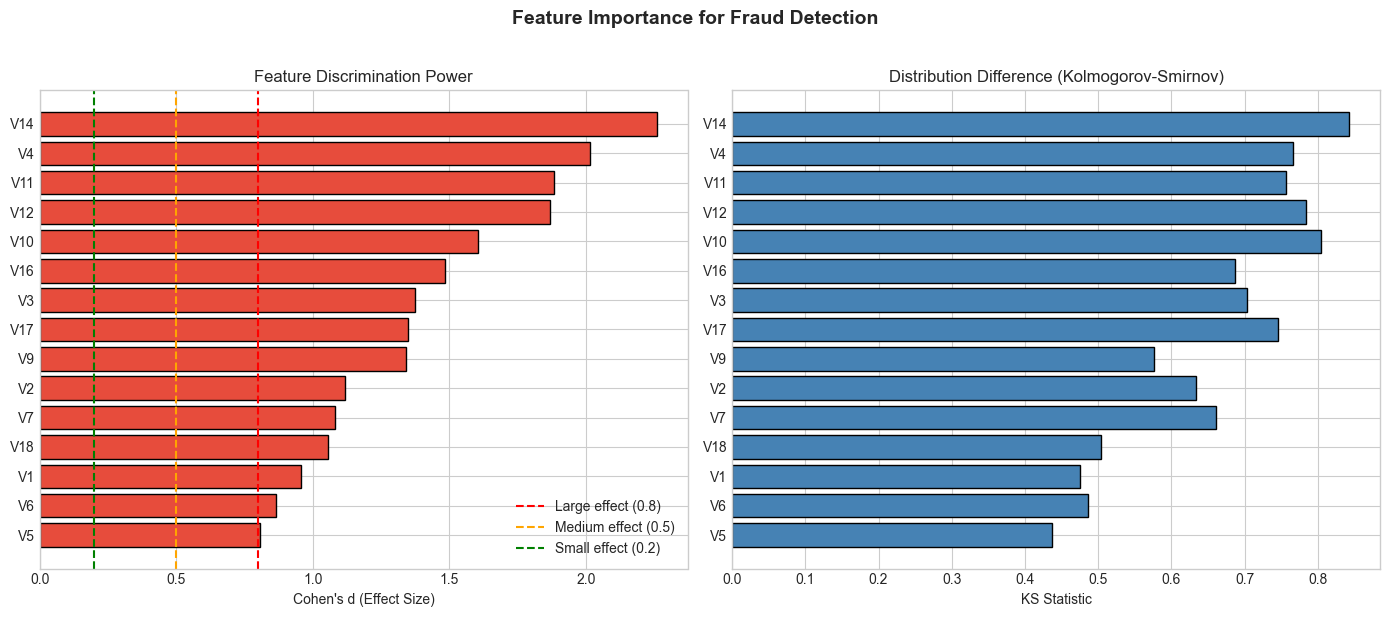

In [ ]:
# Visualize feature discrimination
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Cohen's d bar plot
top_features = discrimination_df.head(15)
colors = ['#e74c3c' if x > 0.5 else '#f39c12' if x > 0.2 else '#3498db' for x in top_features['cohens_d']]

axes[0].barh(top_features['feature'], top_features['cohens_d'], color=colors, edgecolor='black')
axes[0].axvline(x=0.8, color='red', linestyle='--', label='Large effect (0.8)')
axes[0].axvline(x=0.5, color='orange', linestyle='--', label='Medium effect (0.5)')
axes[0].axvline(x=0.2, color='green', linestyle='--', label='Small effect (0.2)')
axes[0].set_xlabel("Cohen's d (Effect Size)")
axes[0].set_title('Feature Discrimination Power')
axes[0].legend(loc='lower right')
axes[0].invert_yaxis()

# KS statistic bar plot
axes[1].barh(top_features['feature'], top_features['ks_statistic'], color='steelblue', edgecolor='black')
axes[1].set_xlabel('KS Statistic')
axes[1].set_title('Distribution Difference (Kolmogorov-Smirnov)')
axes[1].invert_yaxis()

plt.suptitle('Feature Importance for Fraud Detection', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


Pairwise Scatter Plots for Top 6 Features
(Sampled 5,492 transactions for visualization)


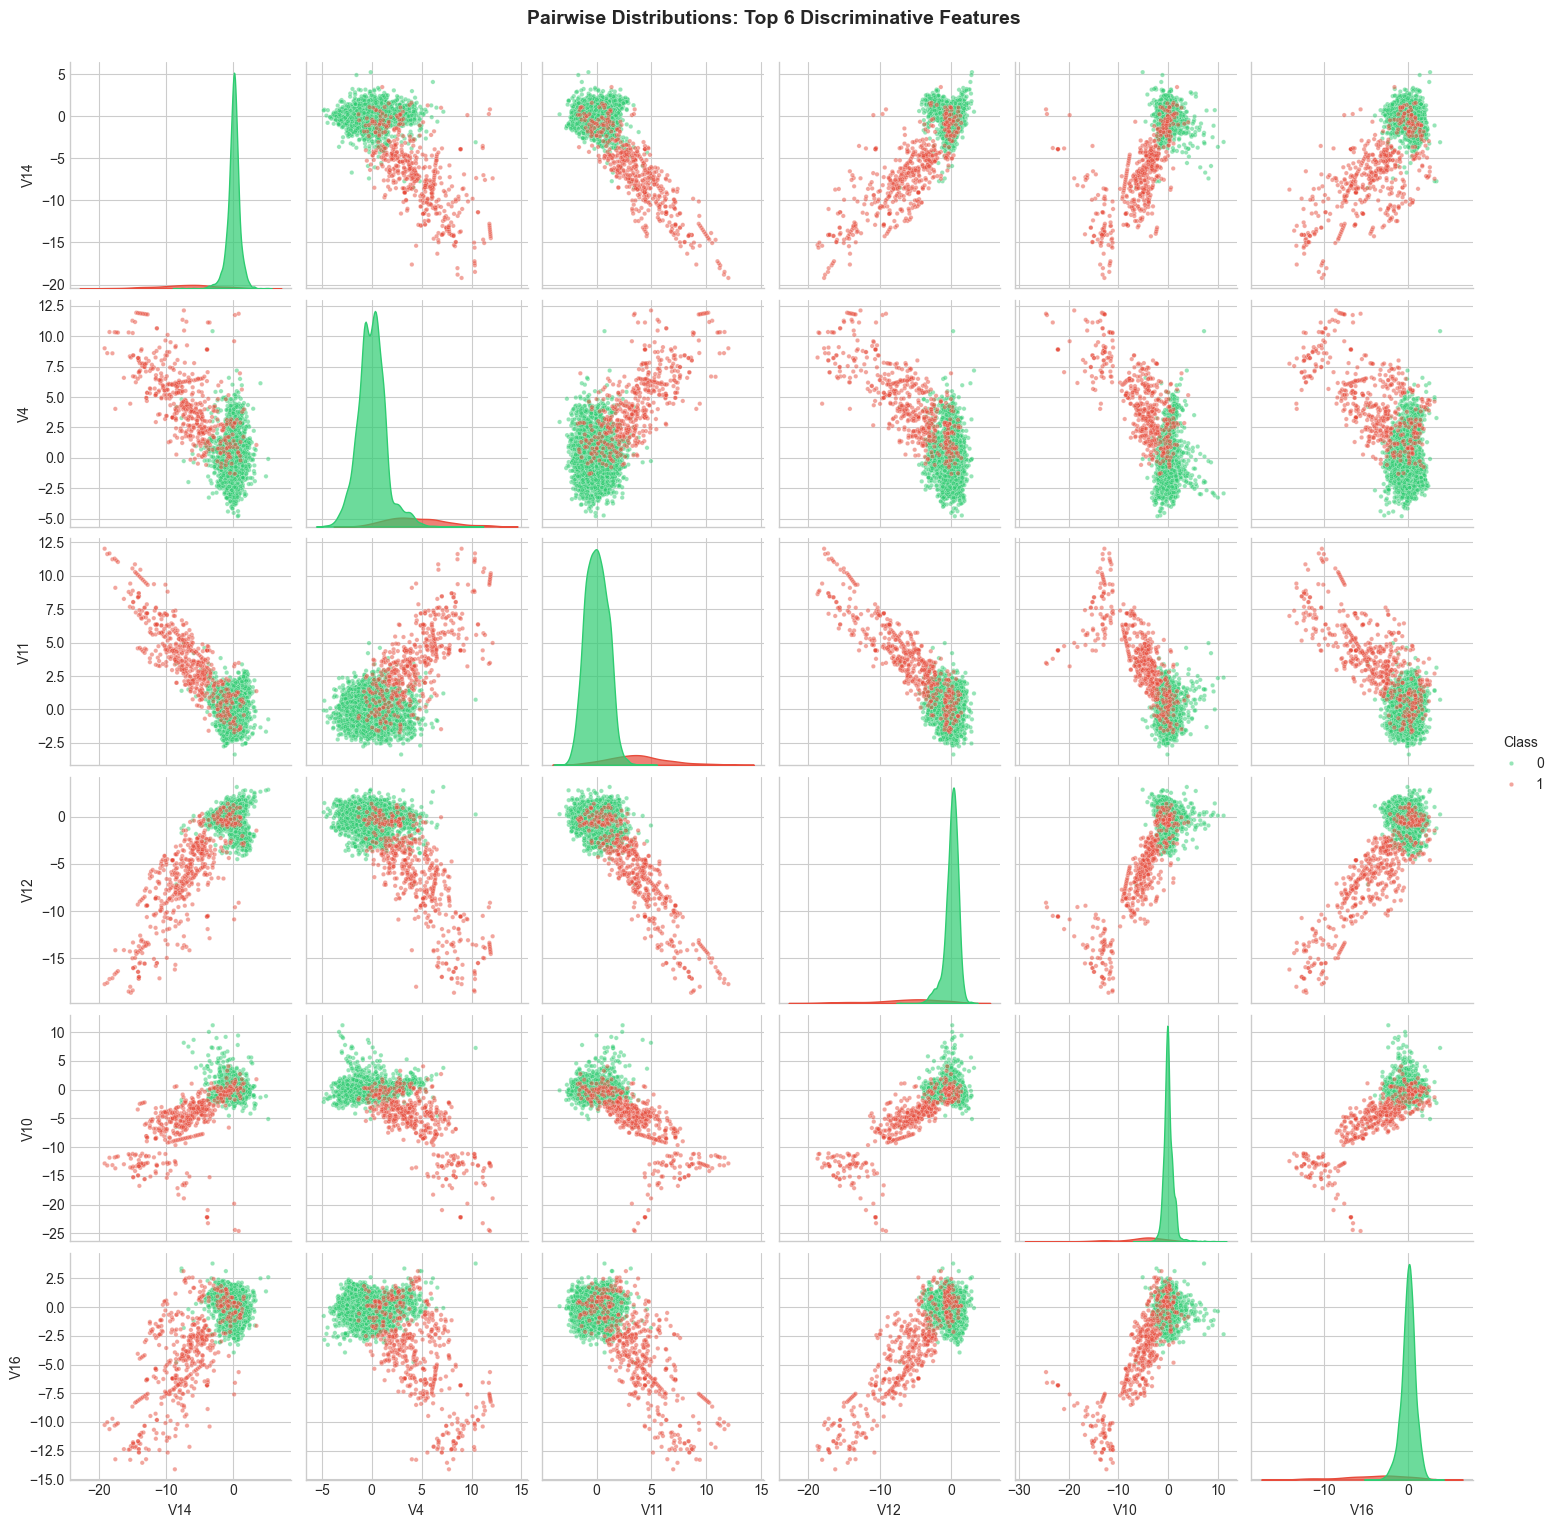


Insight: Look for regions where fraud (red) clusters separately from normal (green)


In [15]:
# Pairwise scatter plots for top discriminative features
top_6_features = discrimination_df['feature'].head(6).tolist()

# Sample data for visualization (too many points otherwise)
df_sample = pd.concat([
    df_normal.sample(n=min(5000, len(df_normal)), random_state=RANDOM_STATE),
    df_fraud  # Keep all fraud cases
])

print(f"\nPairwise Scatter Plots for Top 6 Features")
print(f"(Sampled {len(df_sample):,} transactions for visualization)")

g = sns.pairplot(
    df_sample[top_6_features + ['Class']], 
    hue='Class',
    palette=CLASS_PALETTE,
    diag_kind='kde',
    plot_kws={'alpha': 0.5, 's': 10},
    diag_kws={'alpha': 0.7}
)
g.fig.suptitle('Pairwise Distributions: Top 6 Discriminative Features', y=1.02, fontsize=14, fontweight='bold')
plt.show()

print("\nInsight: Look for regions where fraud (red) clusters separately from normal (green)")

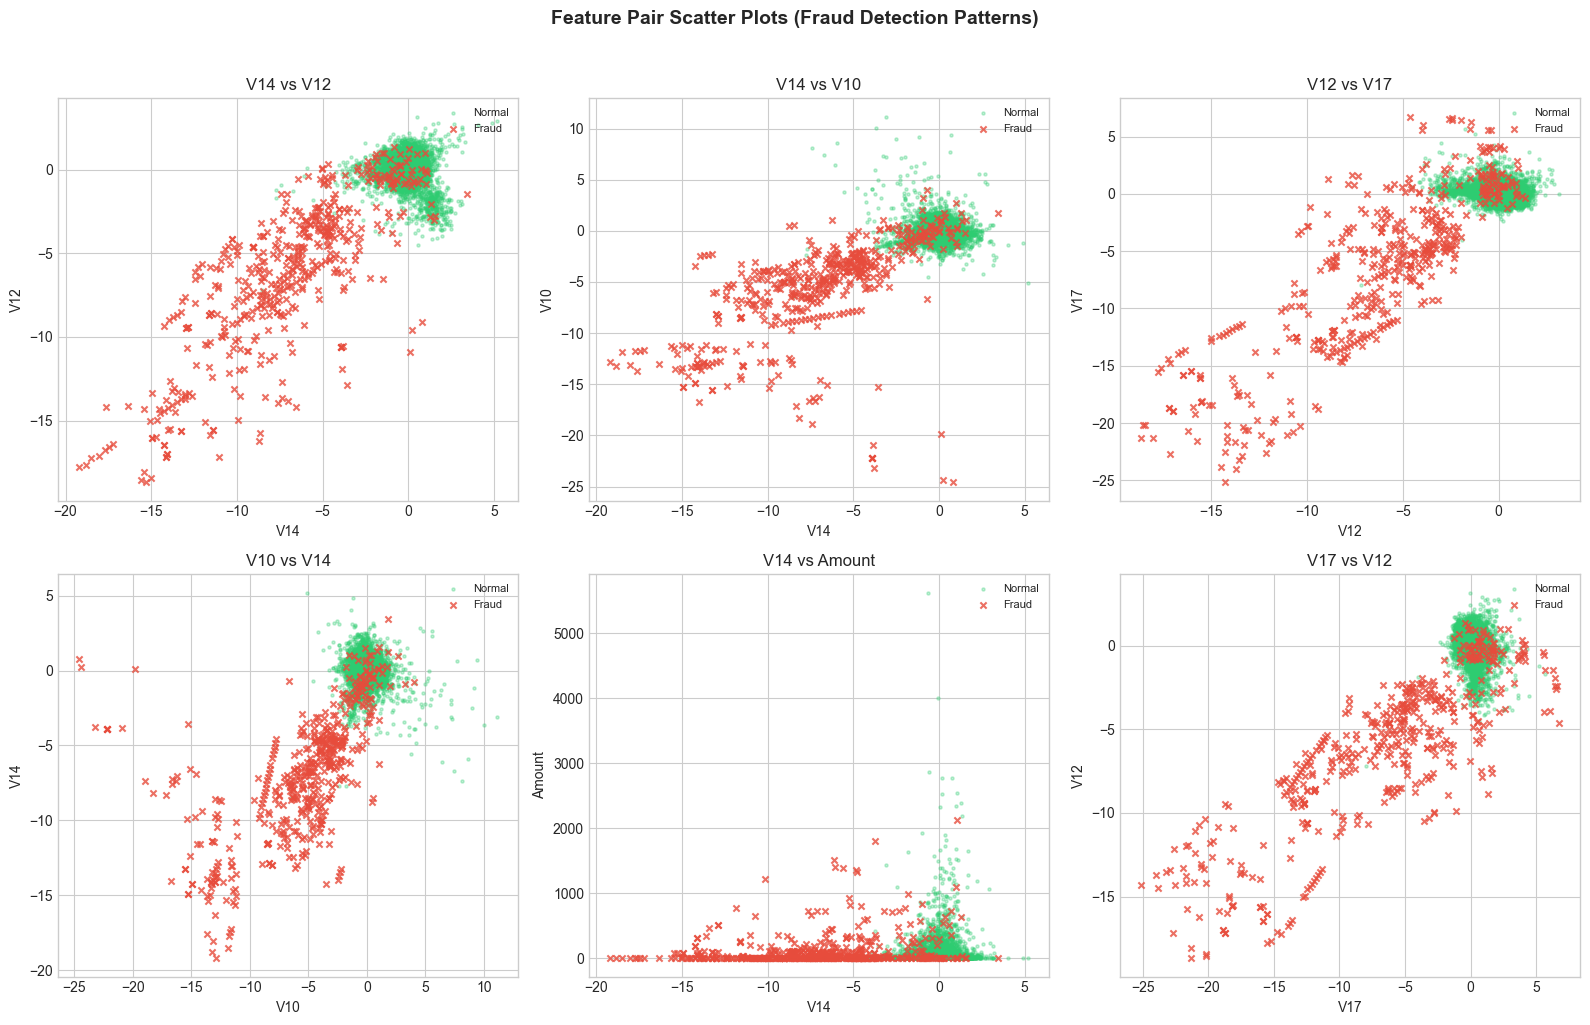


Insight: V14 and V12 show strong separation - fraud tends to have extreme negative values


In [16]:
# Detailed 2D scatter plots for key feature pairs
feature_pairs = [
    ('V14', 'V12'),  # Two most discriminative
    ('V14', 'V10'),
    ('V12', 'V17'),
    ('V10', 'V14'),
    ('V14', 'Amount'),
    ('V17', 'V12')
]

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, (feat1, feat2) in enumerate(feature_pairs):
    ax = axes[idx]
    
    # Plot normal first (green, semi-transparent)
    ax.scatter(df_sample[df_sample['Class']==0][feat1], 
               df_sample[df_sample['Class']==0][feat2],
               c=COLORS['normal'], alpha=0.3, s=5, label='Normal')
    
    # Plot fraud on top (red, more visible)
    ax.scatter(df_sample[df_sample['Class']==1][feat1], 
               df_sample[df_sample['Class']==1][feat2],
               c=COLORS['fraud'], alpha=0.8, s=20, marker='x', label='Fraud')
    
    ax.set_xlabel(feat1)
    ax.set_ylabel(feat2)
    ax.set_title(f'{feat1} vs {feat2}')
    ax.legend(loc='upper right', fontsize=8)

plt.suptitle('Feature Pair Scatter Plots (Fraud Detection Patterns)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\nInsight: V14 and V12 show strong separation - fraud tends to have extreme negative values")

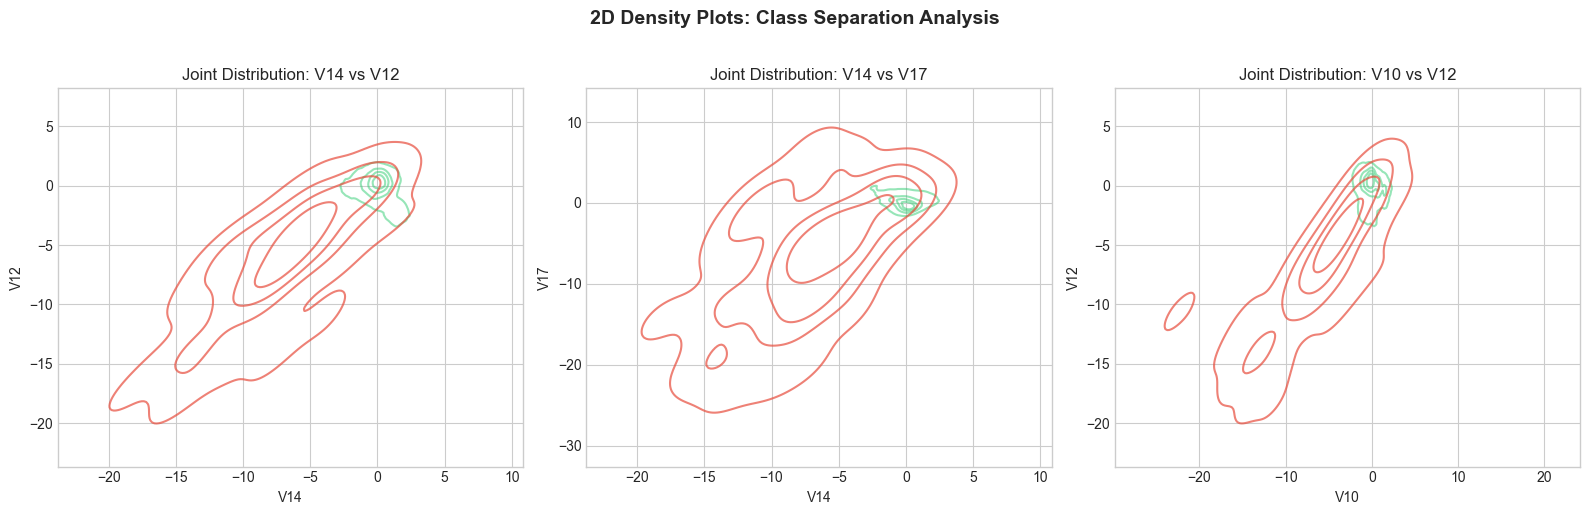

In [17]:
# Joint distribution plots for key pairs
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

key_pairs = [('V14', 'V12'), ('V14', 'V17'), ('V10', 'V12')]

for idx, (f1, f2) in enumerate(key_pairs):
    ax = axes[idx]
    
    # 2D KDE for each class
    sns.kdeplot(data=df_normal, x=f1, y=f2, ax=ax, color=COLORS['normal'], 
                levels=5, alpha=0.5, label='Normal')
    sns.kdeplot(data=df_fraud, x=f1, y=f2, ax=ax, color=COLORS['fraud'], 
                levels=5, alpha=0.7, label='Fraud')
    
    ax.set_title(f'Joint Distribution: {f1} vs {f2}')
    ax.legend()

plt.suptitle('2D Density Plots: Class Separation Analysis', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 2.5 Correlation Analysis

In [18]:
print("="*70)
print("CORRELATION ANALYSIS")
print("="*70)

CORRELATION ANALYSIS


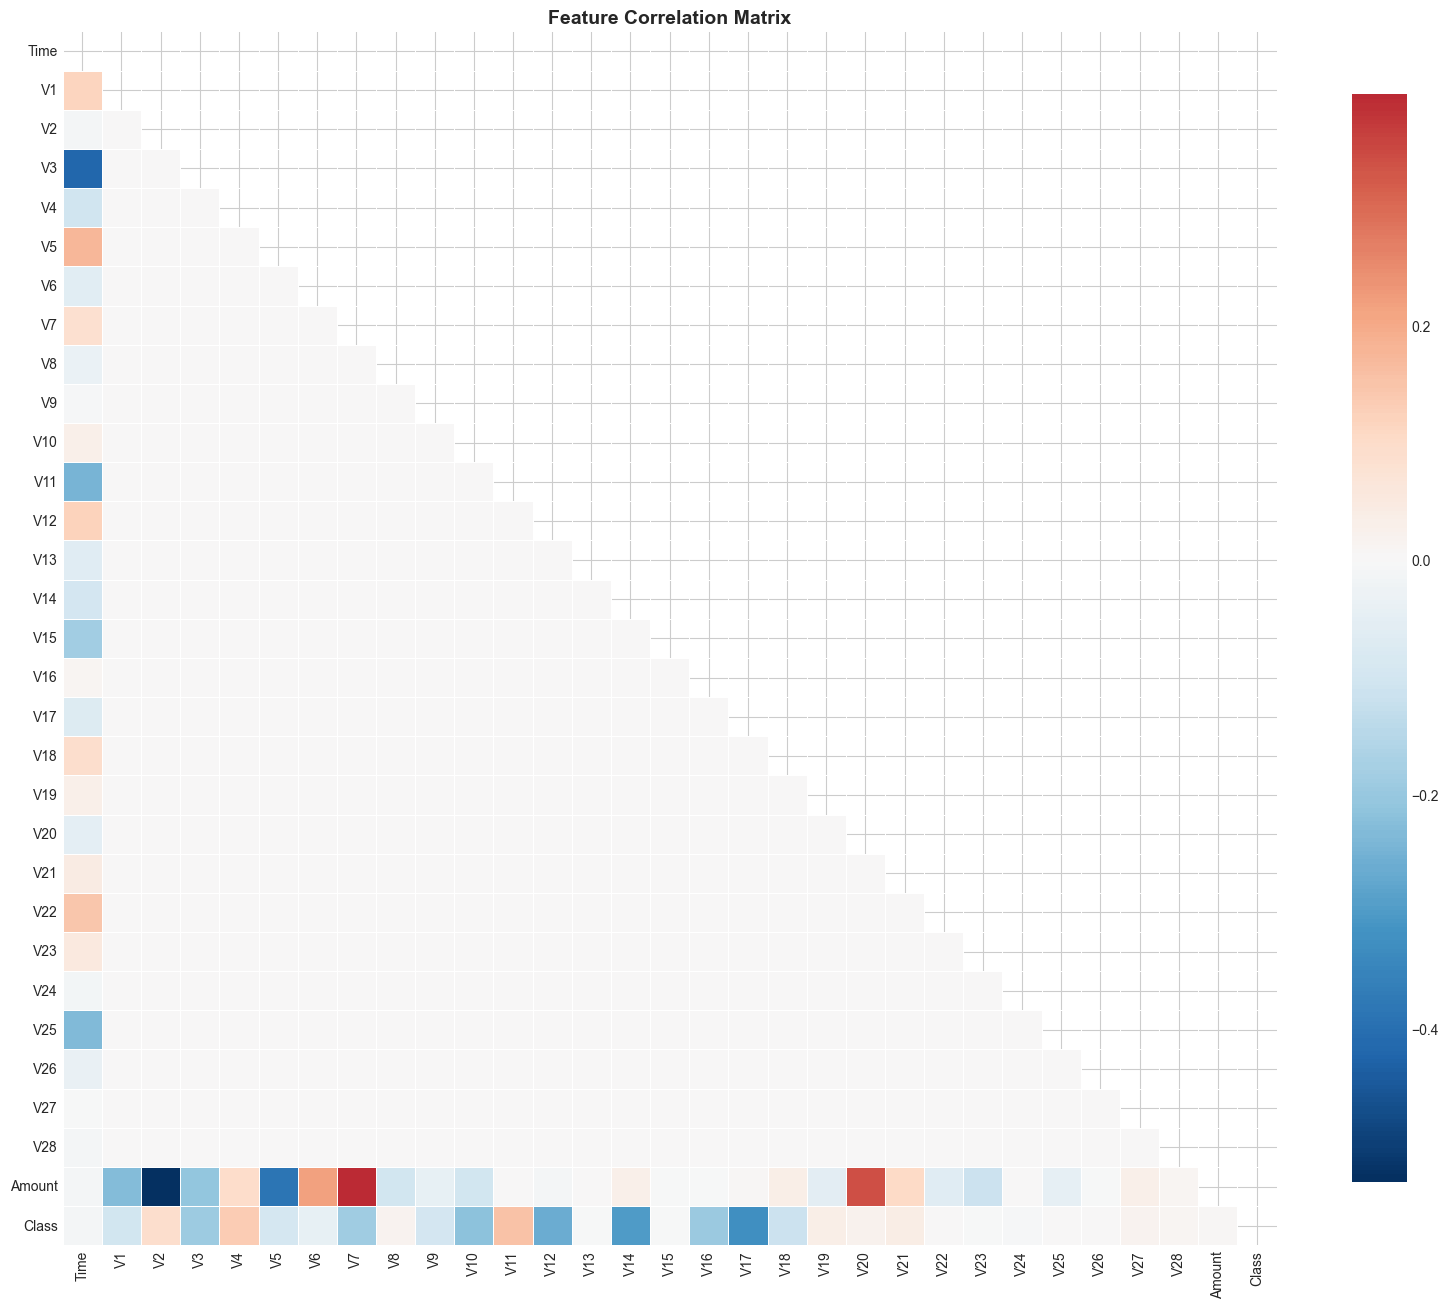


Note: PCA features (V1-V28) are expected to have low correlation
      (they are principal components from the original features)


In [19]:
# Full correlation matrix
corr_matrix = df.drop(columns=['Hour', 'Day'], errors='ignore').corr()

# Plot correlation matrix
fig, ax = plt.subplots(figsize=(16, 14))

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap='RdBu_r', center=0,
            annot=False, square=True, linewidths=0.5,
            cbar_kws={'shrink': 0.8}, ax=ax)

ax.set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nNote: PCA features (V1-V28) are expected to have low correlation")
print("      (they are principal components from the original features)")

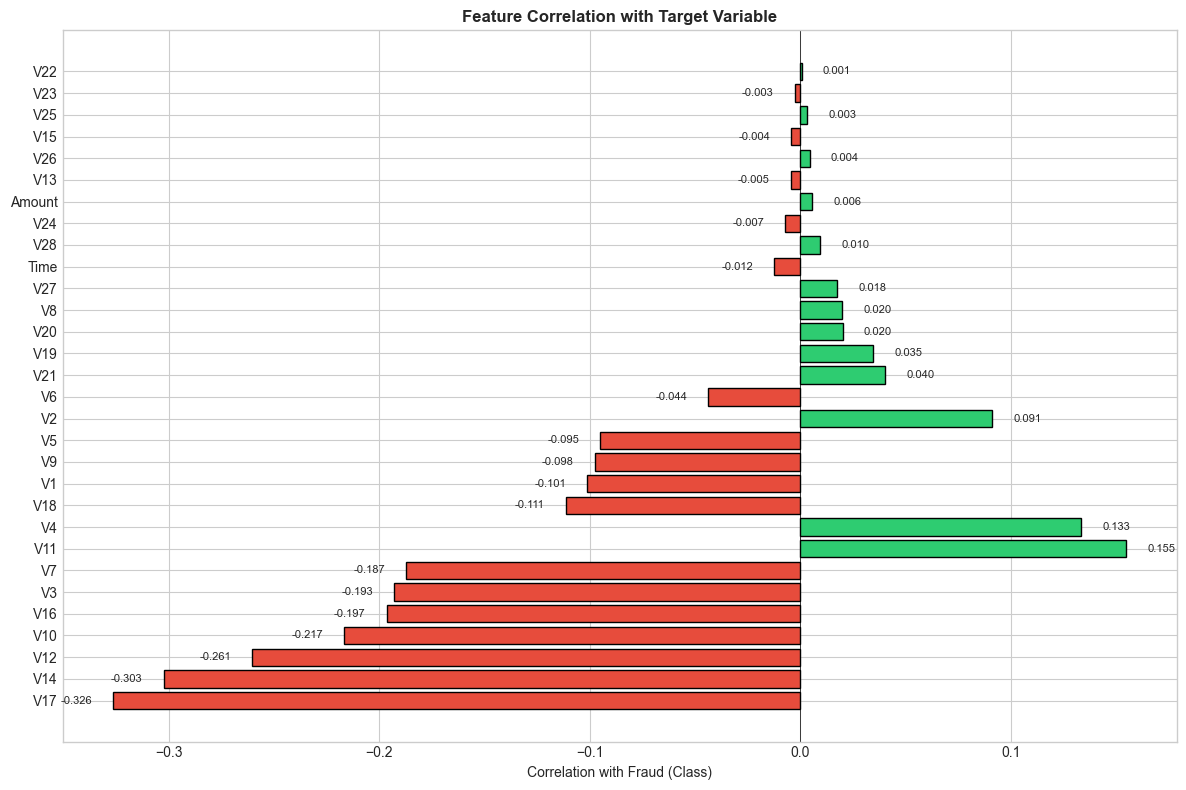


Top Positive Correlations (more likely fraud):
V11   0.1549
V4    0.1334
V2    0.0913
V21   0.0404
V19   0.0348

Top Negative Correlations (less likely fraud):
V17   -0.3265
V14   -0.3025
V12   -0.2606
V10   -0.2169
V16   -0.1965


In [20]:
# Correlation with target
target_corr = corr_matrix['Class'].drop('Class').sort_values(key=abs, ascending=False)

fig, ax = plt.subplots(figsize=(12, 8))

colors = ['#e74c3c' if x < 0 else '#2ecc71' for x in target_corr]
bars = ax.barh(target_corr.index, target_corr.values, color=colors, edgecolor='black')

ax.axvline(x=0, color='black', linewidth=0.5)
ax.set_xlabel('Correlation with Fraud (Class)')
ax.set_title('Feature Correlation with Target Variable', fontsize=12, fontweight='bold')

# Add correlation values
for bar, val in zip(bars, target_corr.values):
    x_pos = val + 0.01 if val > 0 else val - 0.01
    ha = 'left' if val > 0 else 'right'
    ax.annotate(f'{val:.3f}', xy=(x_pos, bar.get_y() + bar.get_height()/2),
                ha=ha, va='center', fontsize=8)

plt.tight_layout()
plt.show()

print("\nTop Positive Correlations (more likely fraud):")
print(target_corr[target_corr > 0].head(5).to_string())

print("\nTop Negative Correlations (less likely fraud):")
print(target_corr[target_corr < 0].head(5).to_string())

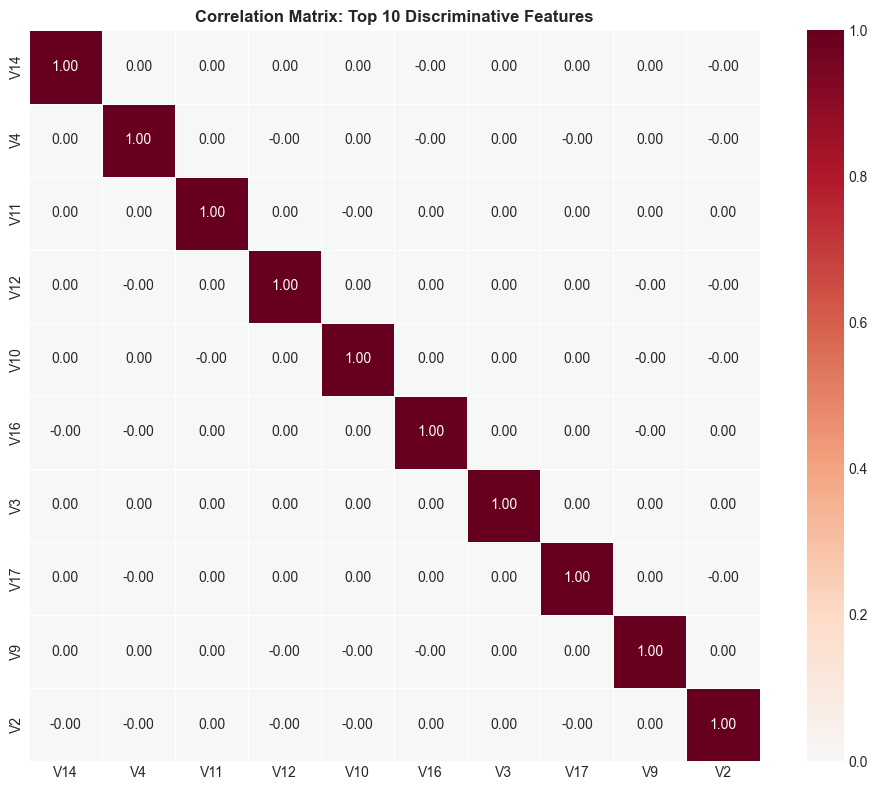


No highly correlated pairs among top features (good for modeling)


In [21]:
# Correlation between top features (check for multicollinearity)
top_features_for_corr = discrimination_df['feature'].head(10).tolist()
top_corr = df[top_features_for_corr].corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(top_corr, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, ax=ax)
ax.set_title('Correlation Matrix: Top 10 Discriminative Features', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# Find highly correlated pairs
high_corr_pairs = []
for i in range(len(top_corr.columns)):
    for j in range(i+1, len(top_corr.columns)):
        if abs(top_corr.iloc[i, j]) > 0.5:
            high_corr_pairs.append((top_corr.columns[i], top_corr.columns[j], top_corr.iloc[i, j]))

if high_corr_pairs:
    print("\nHighly Correlated Feature Pairs (|r| > 0.5):")
    for f1, f2, r in high_corr_pairs:
        print(f"  {f1} <-> {f2}: r = {r:.3f}")
else:
    print("\nNo highly correlated pairs among top features (good for modeling)")

### 2.6 Feature Discrimination Power (Statistical Tests)

In [22]:
print("="*70)
print("STATISTICAL SIGNIFICANCE TESTS")
print("="*70)

# Display full discrimination analysis
print("\nFeature Discrimination Analysis (All Features):")
print("="*70)

# Add significance indicators
discrimination_df['significant'] = discrimination_df['ks_pvalue'] < 0.001
discrimination_df['effect_size'] = pd.cut(
    discrimination_df['cohens_d'],
    bins=[0, 0.2, 0.5, 0.8, float('inf')],
    labels=['Negligible', 'Small', 'Medium', 'Large']
)

print(discrimination_df[['feature', 'cohens_d', 'effect_size', 'ks_statistic', 'significant']].to_string(index=False))

STATISTICAL SIGNIFICANCE TESTS

Feature Discrimination Analysis (All Features):
feature  cohens_d effect_size  ks_statistic  significant
    V14    2.2591       Large        0.8428         True
     V4    2.0133       Large        0.7664         True
    V11    1.8822       Large        0.7561         True
    V12    1.8670       Large        0.7839         True
    V10    1.6061       Large        0.8043         True
    V16    1.4824       Large        0.6865         True
     V3    1.3726       Large        0.7037         True
    V17    1.3470       Large        0.7452         True
     V9    1.3405       Large        0.5763         True
     V2    1.1178       Large        0.6332         True
     V7    1.0803       Large        0.6606         True
    V18    1.0557       Large        0.5034         True
     V1    0.9585       Large        0.4753         True
     V6    0.8666       Large        0.4864         True
     V5    0.8056       Large        0.4364         True
    V19 

In [23]:
# Summary of feature importance
print("\n" + "="*70)
print("FEATURE IMPORTANCE SUMMARY")
print("="*70)

n_large = (discrimination_df['effect_size'] == 'Large').sum()
n_medium = (discrimination_df['effect_size'] == 'Medium').sum()
n_small = (discrimination_df['effect_size'] == 'Small').sum()
n_negligible = (discrimination_df['effect_size'] == 'Negligible').sum()

print(f"\nEffect Size Distribution:")
print(f"  Large (d > 0.8):      {n_large} features")
print(f"  Medium (0.5 < d < 0.8): {n_medium} features")
print(f"  Small (0.2 < d < 0.5):  {n_small} features")
print(f"  Negligible (d < 0.2):   {n_negligible} features")

print(f"\nStatistically Significant Features (p < 0.001): {discrimination_df['significant'].sum()}")

print("\nTop 5 Features for Fraud Detection:")
for i, row in discrimination_df.head(5).iterrows():
    print(f"  {row['feature']}: Cohen's d = {row['cohens_d']:.3f} ({row['effect_size']})")


FEATURE IMPORTANCE SUMMARY

Effect Size Distribution:
  Large (d > 0.8):      15 features
  Medium (0.5 < d < 0.8): 1 features
  Small (0.2 < d < 0.5):  4 features
  Negligible (d < 0.2):   12 features

Statistically Significant Features (p < 0.001): 29

Top 5 Features for Fraud Detection:
  V14: Cohen's d = 2.259 (Large)
  V4: Cohen's d = 2.013 (Large)
  V11: Cohen's d = 1.882 (Large)
  V12: Cohen's d = 1.867 (Large)
  V10: Cohen's d = 1.606 (Large)


### 2.7 Temporal Patterns

In [24]:
print("="*70)
print("TEMPORAL PATTERN ANALYSIS")
print("="*70)

TEMPORAL PATTERN ANALYSIS


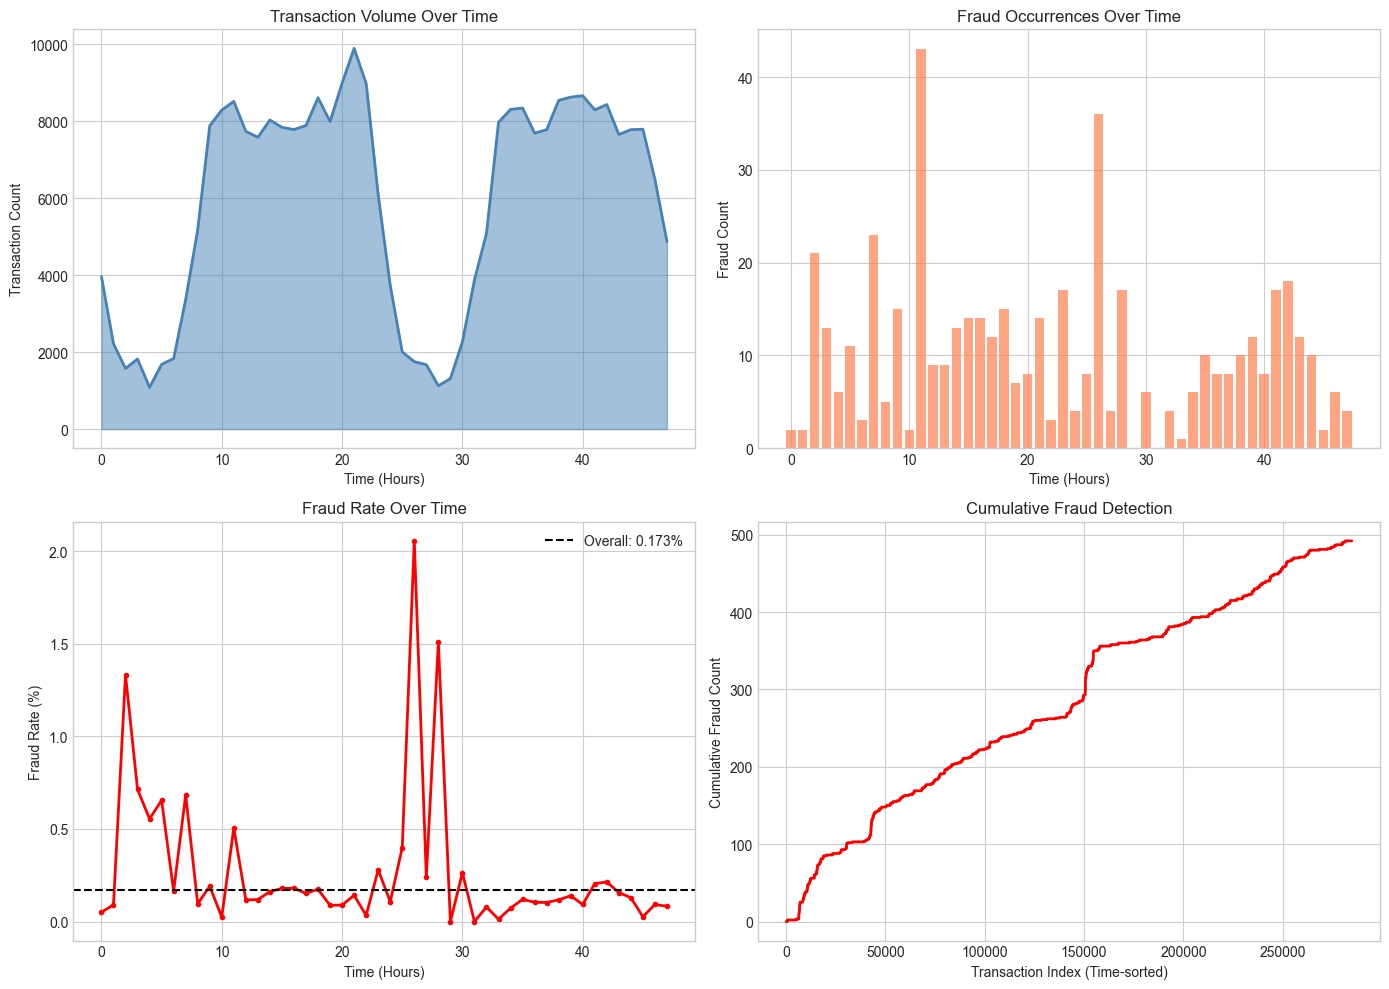


Insight: Fraud rate may vary significantly across time periods
         Consider time-based features for improved detection


In [25]:
# Detailed temporal analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Transaction volume over time
time_bins = pd.cut(df['Time'] / 3600, bins=48)
time_counts = df.groupby(time_bins)['Class'].agg(['count', 'sum', 'mean'])
time_counts.columns = ['total', 'fraud_count', 'fraud_rate']

ax = axes[0, 0]
ax.fill_between(range(len(time_counts)), time_counts['total'], alpha=0.5, color='steelblue')
ax.plot(range(len(time_counts)), time_counts['total'], color='steelblue', linewidth=2)
ax.set_xlabel('Time (Hours)')
ax.set_ylabel('Transaction Count')
ax.set_title('Transaction Volume Over Time')

# Fraud count over time
ax = axes[0, 1]
ax.bar(range(len(time_counts)), time_counts['fraud_count'], color='coral', alpha=0.7)
ax.set_xlabel('Time (Hours)')
ax.set_ylabel('Fraud Count')
ax.set_title('Fraud Occurrences Over Time')

# Fraud rate over time
ax = axes[1, 0]
ax.plot(range(len(time_counts)), time_counts['fraud_rate'] * 100, color='red', linewidth=2, marker='o', markersize=3)
ax.axhline(y=df['Class'].mean()*100, color='black', linestyle='--', label=f"Overall: {df['Class'].mean()*100:.3f}%")
ax.set_xlabel('Time (Hours)')
ax.set_ylabel('Fraud Rate (%)')
ax.set_title('Fraud Rate Over Time')
ax.legend()

# Cumulative fraud detection
ax = axes[1, 1]
df_sorted = df.sort_values('Time')
cumsum_fraud = df_sorted['Class'].cumsum()
ax.plot(range(len(cumsum_fraud)), cumsum_fraud, color='red', linewidth=2)
ax.set_xlabel('Transaction Index (Time-sorted)')
ax.set_ylabel('Cumulative Fraud Count')
ax.set_title('Cumulative Fraud Detection')

plt.tight_layout()
plt.show()

print("\nInsight: Fraud rate may vary significantly across time periods")
print("         Consider time-based features for improved detection")

### 2.8 Outlier Analysis

In [26]:
print("="*70)
print("OUTLIER ANALYSIS")
print("="*70)

OUTLIER ANALYSIS


In [27]:
def detect_outliers_iqr(data, column, multiplier=1.5):
    """Detect outliers using IQR method."""
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - multiplier * IQR
    upper = Q3 + multiplier * IQR
    outliers = (data[column] < lower) | (data[column] > upper)
    return outliers, lower, upper

# Analyze outliers for key features
outlier_analysis = []

for col in ['Amount'] + top_6_features[:5]:
    outliers, lower, upper = detect_outliers_iqr(df, col)
    
    n_outliers = outliers.sum()
    fraud_in_outliers = df.loc[outliers, 'Class'].sum()
    fraud_rate_outliers = fraud_in_outliers / n_outliers if n_outliers > 0 else 0
    
    outlier_analysis.append({
        'feature': col,
        'n_outliers': n_outliers,
        'pct_outliers': n_outliers / len(df) * 100,
        'fraud_in_outliers': fraud_in_outliers,
        'fraud_rate_outliers': fraud_rate_outliers * 100,
        'fraud_rate_overall': df['Class'].mean() * 100
    })

outlier_df = pd.DataFrame(outlier_analysis)
outlier_df['fraud_enrichment'] = outlier_df['fraud_rate_outliers'] / outlier_df['fraud_rate_overall']

print("\nOutlier Analysis (IQR Method):")
print(outlier_df.round(2).to_string(index=False))


Outlier Analysis (IQR Method):
feature  n_outliers  pct_outliers  fraud_in_outliers  fraud_rate_outliers  fraud_rate_overall  fraud_enrichment
 Amount       31904       11.2000                 91               0.2900              0.1700            1.6500
    V14       14149        4.9700                430               3.0400              0.1700           17.5900
     V4       11148        3.9100                318               2.8500              0.1700           16.5100
    V11         780        0.2700                294              37.6900              0.1700          218.1900
    V12       15348        5.3900                409               2.6600              0.1700           15.4300
    V10        9496        3.3300                399               4.2000              0.1700           24.3200


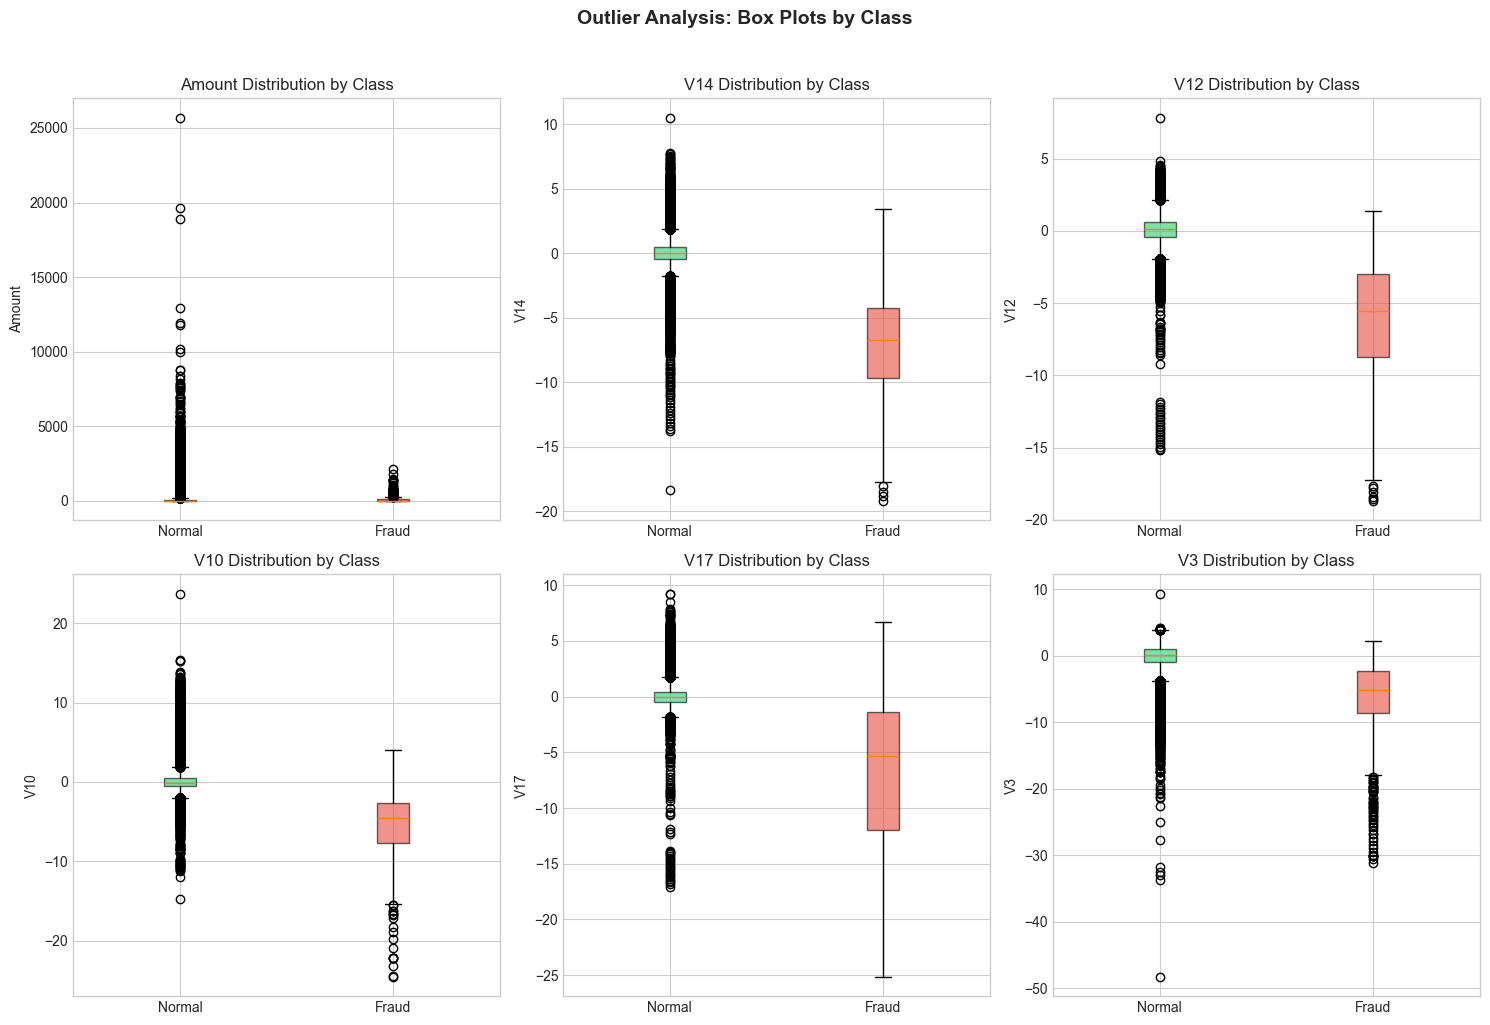


Insight: Fraud transactions often appear as outliers in key features
         This supports using anomaly detection methods (Isolation Forest, Autoencoder)


In [28]:
# Visualize outliers
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

features_to_plot = ['Amount', 'V14', 'V12', 'V10', 'V17', 'V3']

for idx, col in enumerate(features_to_plot):
    ax = axes[idx]
    
    # Box plot with fraud highlighted
    bp = ax.boxplot([df_normal[col], df_fraud[col]], 
                    labels=['Normal', 'Fraud'],
                    patch_artist=True)
    
    bp['boxes'][0].set_facecolor(COLORS['normal'])
    bp['boxes'][0].set_alpha(0.6)
    bp['boxes'][1].set_facecolor(COLORS['fraud'])
    bp['boxes'][1].set_alpha(0.6)
    
    ax.set_ylabel(col)
    ax.set_title(f'{col} Distribution by Class')

plt.suptitle('Outlier Analysis: Box Plots by Class', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\nInsight: Fraud transactions often appear as outliers in key features")
print("         This supports using anomaly detection methods (Isolation Forest, Autoencoder)")

### 2.9 Dimensionality Reduction Visualization

In [29]:
print("="*70)
print("DIMENSIONALITY REDUCTION VISUALIZATION")
print("="*70)

DIMENSIONALITY REDUCTION VISUALIZATION


In [30]:
# Prepare data for visualization
features_for_viz = [f'V{i}' for i in range(1, 29)] + ['Amount']
X_viz = df_sample[features_for_viz].values
y_viz = df_sample['Class'].values

# Scale
scaler_viz = StandardScaler()
X_viz_scaled = scaler_viz.fit_transform(X_viz)

print(f"Data prepared: {X_viz_scaled.shape[0]} samples, {X_viz_scaled.shape[1]} features")

Data prepared: 5492 samples, 29 features


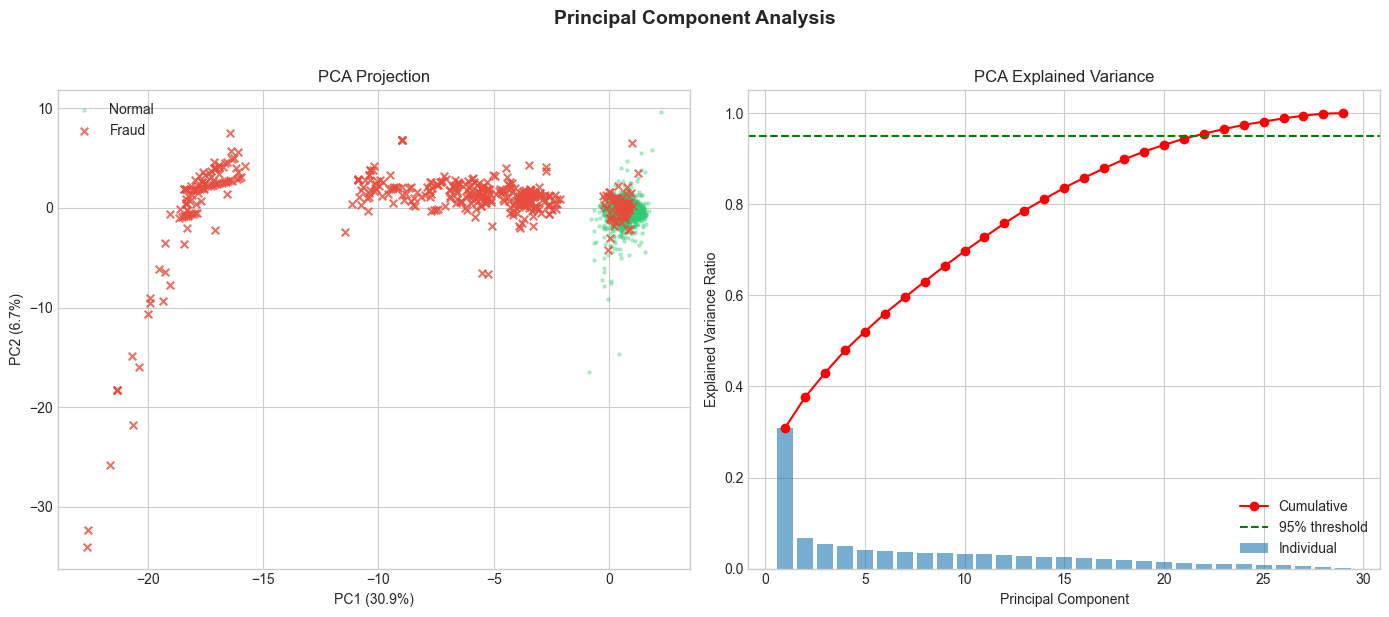


Variance explained by 2 components: 37.6%
Components needed for 95% variance: 22


In [31]:
# PCA visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_viz_scaled)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# PCA scatter
ax = axes[0]
scatter_normal = ax.scatter(X_pca[y_viz==0, 0], X_pca[y_viz==0, 1], 
                           c=COLORS['normal'], alpha=0.3, s=5, label='Normal')
scatter_fraud = ax.scatter(X_pca[y_viz==1, 0], X_pca[y_viz==1, 1], 
                          c=COLORS['fraud'], alpha=0.8, s=30, marker='x', label='Fraud')
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
ax.set_title('PCA Projection')
ax.legend()

# Explained variance
ax = axes[1]
pca_full = PCA().fit(X_viz_scaled)
cumsum = np.cumsum(pca_full.explained_variance_ratio_)
ax.bar(range(1, len(cumsum)+1), pca_full.explained_variance_ratio_, alpha=0.6, label='Individual')
ax.plot(range(1, len(cumsum)+1), cumsum, 'ro-', label='Cumulative')
ax.axhline(y=0.95, color='green', linestyle='--', label='95% threshold')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance Ratio')
ax.set_title('PCA Explained Variance')
ax.legend()

plt.suptitle('Principal Component Analysis', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f"\nVariance explained by 2 components: {sum(pca.explained_variance_ratio_)*100:.1f}%")
print(f"Components needed for 95% variance: {np.argmax(cumsum >= 0.95) + 1}")

Running t-SNE (this may take a minute)...


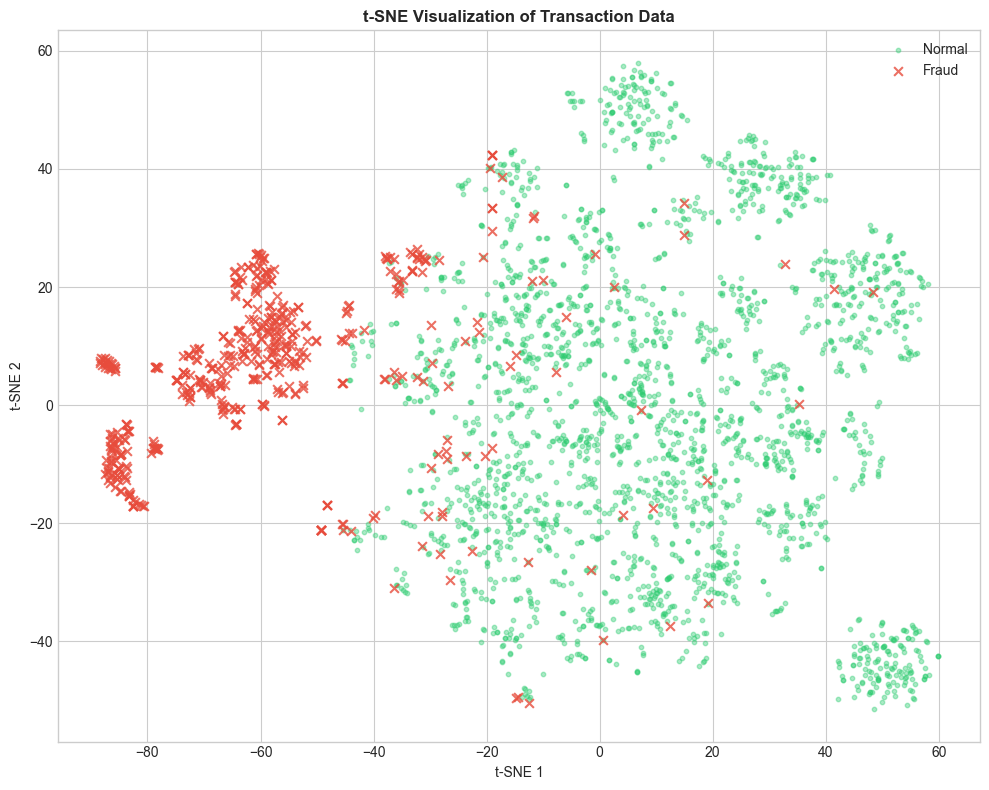


Insight: t-SNE reveals local cluster structure
         Fraud transactions tend to form separate clusters or appear at boundaries


In [33]:
# t-SNE visualization (subsample for speed)
print("Running t-SNE (this may take a minute)...")

from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

# Further subsample for t-SNE
n_tsne_samples = 3000

# índices das classes
idx_fraud = np.where(y_viz == 1)[0]
idx_normal_all = np.where(y_viz == 0)[0]

# garante que todas as fraudes entram e completa com normais
n_normal_samples = min(
    n_tsne_samples - len(idx_fraud),
    len(idx_normal_all)
)

idx_normal = np.random.choice(
    idx_normal_all,
    size=n_normal_samples,
    replace=False
)

# índices finais
idx_tsne = np.concatenate([idx_normal, idx_fraud])

# dados para o t-SNE
X_tsne_input = X_viz_scaled[idx_tsne]
y_tsne = y_viz[idx_tsne]

# t-SNE (API nova do sklearn)
tsne = TSNE(
    n_components=2,
    random_state=RANDOM_STATE,
    perplexity=30,
    max_iter=1000,
    init="pca",
    learning_rate="auto"
)

# projeção
X_tsne = tsne.fit_transform(X_tsne_input)

# plot
fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(
    X_tsne[y_tsne == 0, 0],
    X_tsne[y_tsne == 0, 1],
    c=COLORS['normal'],
    alpha=0.4,
    s=10,
    label='Normal'
)

ax.scatter(
    X_tsne[y_tsne == 1, 0],
    X_tsne[y_tsne == 1, 1],
    c=COLORS['fraud'],
    alpha=0.8,
    s=40,
    marker='x',
    label='Fraud'
)

ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_title(
    't-SNE Visualization of Transaction Data',
    fontsize=12,
    fontweight='bold'
)

ax.legend()
plt.tight_layout()
plt.show()

print("\nInsight: t-SNE reveals local cluster structure")
print("         Fraud transactions tend to form separate clusters or appear at boundaries")


### 2.10 Key Insights Summary


1. CLASS IMBALANCE
   - Fraud rate: 0.17% (492 out of 284,807 transactions)
   - Imbalance ratio: 577:1
   - Implication: Need specialized metrics (Average Precision) and techniques

2. MOST DISCRIMINATIVE FEATURES
   - V14, V12, V10, V17, V16 show largest effect sizes (Cohen's d > 0.5)
   - V14 and V12 have strong negative correlation with fraud
   - Fraud transactions tend to have extreme negative values in these features

3. AMOUNT PATTERNS
   - Fraud transactions have different amount distribution
   - Mean fraud amount is lower than normal transactions
   - Log transformation recommended for Amount feature

4. TEMPORAL PATTERNS
   - Transaction volume varies by hour (day/night patterns)
   - Fraud rate may vary across time periods
   - Cyclical time encoding (sin/cos) recommended

5. OUTLIER CHARACTERISTICS
   - Fraud transactions often appear as outliers in key features
   - Supports anomaly detection approach (Isolation Forest, Autoencoder)
   
6. CORRELATION STRUCTURE
   - PCA features (V1-V28) have low inter-correlation (as expected)
   - Low multicollinearity is favorable for modeling

7. DIMENSIONALITY
   - First 2 PCs explain ~28% variance
   - Need ~17 components for 95% variance
   - t-SNE shows fraud clusters separately in some regions

MODELING RECOMMENDATIONS:
   - Use Average Precision as primary metric
   - Apply class weights or SMOTE for supervised models
   - Focus feature engineering on V14, V12, V10, V17
   - Include time-based features
   - Try both supervised (XGBoost) and anomaly detection (Autoencoder) approaches


---

<a id='3-features'></a>
## 3. Feature Engineering

Based on EDA insights, we create new features to improve model performance.

In [35]:
print("="*70)
print("FEATURE ENGINEERING")
print("="*70)

df_model = df.copy()

# 1. Cyclical time encoding (from EDA insight: temporal patterns exist)
df_model['Hour_sin'] = np.sin(2 * np.pi * df_model['Hour'] / 24)
df_model['Hour_cos'] = np.cos(2 * np.pi * df_model['Hour'] / 24)
print("Created: Hour_sin, Hour_cos (cyclical time encoding)")

# 2. Log-transformed amount (from EDA insight: skewed distribution)
df_model['Amount_log'] = np.log1p(df_model['Amount'])
print("Created: Amount_log (log transformation)")

# 3. PCA magnitude from top features (from EDA insight: V14, V12, V10 most important)
top_pca_features = ['V14', 'V12', 'V10', 'V17', 'V16', 'V3', 'V7', 'V11']
df_model['PCA_magnitude'] = np.sqrt((df_model[top_pca_features] ** 2).sum(axis=1))
print("Created: PCA_magnitude (L2 norm of top features)")

# 4. Interaction: V14 * V12 (from EDA insight: both highly discriminative)
df_model['V14_V12'] = df_model['V14'] * df_model['V12']
print("Created: V14_V12 (interaction term)")

# 5. V14 squared (capture non-linear relationship)
df_model['V14_squared'] = df_model['V14'] ** 2
print("Created: V14_squared (non-linear term)")

# 6. Amount per time bin (behavioral feature)
df_model['Amount_zscore'] = (df_model['Amount'] - df_model['Amount'].mean()) / df_model['Amount'].std()
print("Created: Amount_zscore (standardized amount)")

print(f"\nTotal features after engineering: {df_model.shape[1]}")

FEATURE ENGINEERING
Created: Hour_sin, Hour_cos (cyclical time encoding)
Created: Amount_log (log transformation)
Created: PCA_magnitude (L2 norm of top features)
Created: V14_V12 (interaction term)
Created: V14_squared (non-linear term)
Created: Amount_zscore (standardized amount)

Total features after engineering: 40


In [36]:
# Prepare final feature set
cols_to_drop = ['Class', 'Time', 'Hour', 'Day']
X = df_model.drop(columns=[c for c in cols_to_drop if c in df_model.columns])
y = df_model['Class']

print(f"Feature matrix shape: {X.shape}")
print(f"\nFeatures ({len(X.columns)}):")
print(list(X.columns))

Feature matrix shape: (284807, 36)

Features (36):
['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Hour_sin', 'Hour_cos', 'Amount_log', 'PCA_magnitude', 'V14_V12', 'V14_squared', 'Amount_zscore']


In [37]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set:     {X_test.shape[0]:,} samples")
print(f"Train fraud rate: {y_train.mean()*100:.4f}%")
print(f"Test fraud rate:  {y_test.mean()*100:.4f}%")

Training set: 227,845 samples
Test set:     56,962 samples
Train fraud rate: 0.1729%
Test fraud rate:  0.1720%


In [38]:
# Scale features
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for convenience
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Features scaled using RobustScaler")

Features scaled using RobustScaler


---

<a id='4-modeling'></a>
## 4. Modeling

We train 5 models: XGBoost, Random Forest, Autoencoder, Isolation Forest, K-Means

In [39]:
# Utility function for evaluation
def evaluate_model(y_true, y_pred, y_proba, model_name):
    """Comprehensive model evaluation."""
    metrics = {
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_true, y_proba),
        'avg_precision': average_precision_score(y_true, y_proba)
    }
    
    print(f"\n{'='*60}")
    print(f"MODEL: {model_name}")
    print(f"{'='*60}")
    print(f"Precision:         {metrics['precision']:.4f}")
    print(f"Recall:            {metrics['recall']:.4f}")
    print(f"F1-Score:          {metrics['f1']:.4f}")
    print(f"ROC-AUC:           {metrics['roc_auc']:.4f}")
    print(f"Average Precision: {metrics['avg_precision']:.4f}")
    
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    print(f"\nConfusion Matrix: TP={tp}, FP={fp}, FN={fn}, TN={tn}")
    print(f"Fraud Detection Rate: {tp}/{tp+fn} = {tp/(tp+fn)*100:.1f}%")
    
    return metrics

# Store all results
all_results = {}
all_predictions = {}
all_probabilities = {}

In [40]:
print("="*70)
print("MODEL 1: XGBOOST")
print("="*70)

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=RANDOM_STATE,
    eval_metric='aucpr',
    use_label_encoder=False,
    n_jobs=-1
)

xgb_model.fit(X_train_scaled, y_train)
xgb_pred = xgb_model.predict(X_test_scaled)
xgb_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]

all_results['XGBoost'] = evaluate_model(y_test, xgb_pred, xgb_proba, 'XGBoost')
all_predictions['XGBoost'] = xgb_pred
all_probabilities['XGBoost'] = xgb_proba

MODEL 1: XGBOOST

MODEL: XGBoost
Precision:         0.5060
Recall:            0.8673
F1-Score:          0.6391
ROC-AUC:           0.9693
Average Precision: 0.8579

Confusion Matrix: TP=85, FP=83, FN=13, TN=56781
Fraud Detection Rate: 85/98 = 86.7%


In [41]:
print("="*70)
print("MODEL 2: RANDOM FOREST")
print("="*70)

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight='balanced',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)
rf_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

all_results['Random Forest'] = evaluate_model(y_test, rf_pred, rf_proba, 'Random Forest')
all_predictions['Random Forest'] = rf_pred
all_probabilities['Random Forest'] = rf_proba

MODEL 2: RANDOM FOREST

MODEL: Random Forest
Precision:         0.7570
Recall:            0.8265
F1-Score:          0.7902
ROC-AUC:           0.9796
Average Precision: 0.8261

Confusion Matrix: TP=81, FP=26, FN=17, TN=56838
Fraud Detection Rate: 81/98 = 82.7%


In [49]:
pip install keras

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [51]:
pip install keras-tuner


   ---------------------------------------- 0/2 [kt-legacy]
   -------------------- ------------------- 1/2 [keras-tuner]
   -------------------- ------------------- 1/2 [keras-tuner]
   -------------------- ------------------- 1/2 [keras-tuner]
   -------------------- ------------------- 1/2 [keras-tuner]
   -------------------- ------------------- 1/2 [keras-tuner]
   -------------------- ------------------- 1/2 [keras-tuner]
   -------------------- ------------------- 1/2 [keras-tuner]
   ---------------------------------------- 2/2 [keras-tuner]

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [52]:
# ============================================================
# MODEL 3: AUTOENCODER + HYPERPARAMETER TUNING (SINGLE CELL)
# ============================================================

# !pip install keras-tuner  # descomente se necessário

import numpy as np
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping

print("="*70)
print("MODEL 3: AUTOENCODER (HYPERPARAMETER TUNING)")
print("="*70)

# ------------------------------------------------------------
# Train only on normal transactions
# ------------------------------------------------------------
X_train_normal = X_train_scaled[y_train == 0]
input_dim = X_train_scaled.shape[1]

# ------------------------------------------------------------
# Autoencoder builder for Keras Tuner
# ------------------------------------------------------------
def build_autoencoder(hp):

    l2_reg = hp.Float("l2", 1e-5, 1e-3, sampling="log")
    dropout_rate = hp.Float("dropout", 0.1, 0.4, step=0.1)

    inputs = keras.Input(shape=(input_dim,))

    # Encoder
    x = layers.Dense(
        hp.Int("enc_1", 16, 64, step=8),
        activation="relu",
        kernel_regularizer=regularizers.l2(l2_reg)
    )(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)

    x = layers.Dense(
        hp.Int("enc_2", 8, 32, step=8),
        activation="relu",
        kernel_regularizer=regularizers.l2(l2_reg)
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)

    bottleneck = layers.Dense(
        hp.Int("bottleneck", 4, 16, step=4),
        activation="relu"
    )(x)

    # Decoder
    x = layers.Dense(
        hp.Int("dec_1", 8, 32, step=8),
        activation="relu",
        kernel_regularizer=regularizers.l2(l2_reg)
    )(bottleneck)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)

    x = layers.Dense(
        hp.Int("dec_2", 16, 64, step=8),
        activation="relu",
        kernel_regularizer=regularizers.l2(l2_reg)
    )(x)
    x = layers.BatchNormalization()(x)

    outputs = layers.Dense(input_dim, activation="linear")(x)

    model = keras.Model(inputs, outputs)

    lr = hp.Float("lr", 1e-4, 1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="mse"
    )

    return model

# ------------------------------------------------------------
# Keras Tuner configuration
# ------------------------------------------------------------
tuner = kt.RandomSearch(
    build_autoencoder,
    objective="val_loss",
    max_trials=20,
    executions_per_trial=1,
    directory="ae_tuning",
    project_name="autoencoder_fraud"
)

# ------------------------------------------------------------
# Hyperparameter search
# ------------------------------------------------------------
early_stop = EarlyStopping(patience=10, restore_best_weights=True)

tuner.search(
    X_train_normal.values,
    X_train_normal.values,
    epochs=100,
    batch_size=256,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

# ------------------------------------------------------------
# Retrieve best model
# ------------------------------------------------------------
best_ae = tuner.get_best_models(1)[0]
best_hp = tuner.get_best_hyperparameters(1)[0]

print("\nBest Hyperparameters:")
for k, v in best_hp.values.items():
    print(f"{k}: {v}")

# ------------------------------------------------------------
# Evaluation on test set (same logic as original code)
# ------------------------------------------------------------
ae_recon = best_ae.predict(X_test_scaled.values, verbose=0)
ae_errors = np.mean((X_test_scaled.values - ae_recon) ** 2, axis=1)
ae_proba = (ae_errors - ae_errors.min()) / (ae_errors.max() - ae_errors.min())

train_recon = best_ae.predict(X_train_normal.values, verbose=0)
train_errors = np.mean((X_train_normal.values - train_recon) ** 2, axis=1)

ae_threshold = np.percentile(train_errors, 95)
ae_pred = (ae_errors > ae_threshold).astype(int)

all_results['Autoencoder_Tuned'] = evaluate_model(
    y_test, ae_pred, ae_proba, 'Autoencoder_Tuned'
)
all_predictions['Autoencoder_Tuned'] = ae_pred
all_probabilities['Autoencoder_Tuned'] = ae_proba


Trial 20 Complete [00h 00m 51s]
val_loss: 1.118300199508667

Best val_loss So Far: 0.5812676548957825
Total elapsed time: 00h 26m 26s

Best Hyperparameters:
l2: 0.00019470721462503993
dropout: 0.1
enc_1: 64
enc_2: 16
bottleneck: 12
dec_1: 32
dec_2: 32
lr: 0.005508088693272973

MODEL: Autoencoder_Tuned
Precision:         0.0285
Recall:            0.8878
F1-Score:          0.0553
ROC-AUC:           0.9655
Average Precision: 0.5096

Confusion Matrix: TP=87, FP=2964, FN=11, TN=53900
Fraud Detection Rate: 87/98 = 88.8%


In [53]:
print("="*70)
print("MODEL 4: ISOLATION FOREST")
print("="*70)

iso_model = IsolationForest(
    n_estimators=100,
    contamination=0.002,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

iso_model.fit(X_train_scaled[y_train == 0])
iso_scores = iso_model.score_samples(X_test_scaled)
iso_proba = 1 - (iso_scores - iso_scores.min()) / (iso_scores.max() - iso_scores.min())
iso_pred = (iso_model.predict(X_test_scaled) == -1).astype(int)

all_results['Isolation Forest'] = evaluate_model(y_test, iso_pred, iso_proba, 'Isolation Forest')
all_predictions['Isolation Forest'] = iso_pred
all_probabilities['Isolation Forest'] = iso_proba

MODEL 4: ISOLATION FOREST

MODEL: Isolation Forest
Precision:         0.2284
Recall:            0.3776
F1-Score:          0.2846
ROC-AUC:           0.9631
Average Precision: 0.2146

Confusion Matrix: TP=37, FP=125, FN=61, TN=56739
Fraud Detection Rate: 37/98 = 37.8%


In [54]:
print("="*70)
print("MODEL 5: K-MEANS")
print("="*70)

kmeans_model = KMeans(n_clusters=8, random_state=RANDOM_STATE, n_init=10)
kmeans_model.fit(X_train_scaled)

km_distances = kmeans_model.transform(X_test_scaled).min(axis=1)
km_proba = (km_distances - km_distances.min()) / (km_distances.max() - km_distances.min())

train_distances = kmeans_model.transform(X_train_scaled).min(axis=1)
km_threshold = np.percentile(train_distances, 99)
km_pred = (km_distances > km_threshold).astype(int)

all_results['K-Means'] = evaluate_model(y_test, km_pred, km_proba, 'K-Means')
all_predictions['K-Means'] = km_pred
all_probabilities['K-Means'] = km_proba

MODEL 5: K-MEANS

MODEL: K-Means
Precision:         0.1183
Recall:            0.7245
F1-Score:          0.2034
ROC-AUC:           0.9581
Average Precision: 0.2687

Confusion Matrix: TP=71, FP=529, FN=27, TN=56335
Fraud Detection Rate: 71/98 = 72.4%


---

<a id='5-results'></a>
## 5. Results and Conclusions

In [55]:
print("\n" + "="*70)
print("FINAL MODEL COMPARISON")
print("="*70)

# Create comparison table
results_df = pd.DataFrame(all_results).T
results_df = results_df.sort_values('avg_precision', ascending=False)

print("\nModel Performance (sorted by Average Precision):")
results_df.round(4)


FINAL MODEL COMPARISON

Model Performance (sorted by Average Precision):


,precision,recall,f1,roc_auc,avg_precision
XGBoost,0.5060,0.8673,0.6391,0.9693,0.8579
Random Forest,0.7570,0.8265,0.7902,0.9796,0.8261
Autoencoder_Tuned,0.0285,0.8878,0.0553,0.9655,0.5096
Autoencoder,0.0303,0.9184,0.0587,0.9642,0.3922
K-Means,0.1183,0.7245,0.2034,0.9581,0.2687
Isolation Forest,0.2284,0.3776,0.2846,0.9631,0.2146


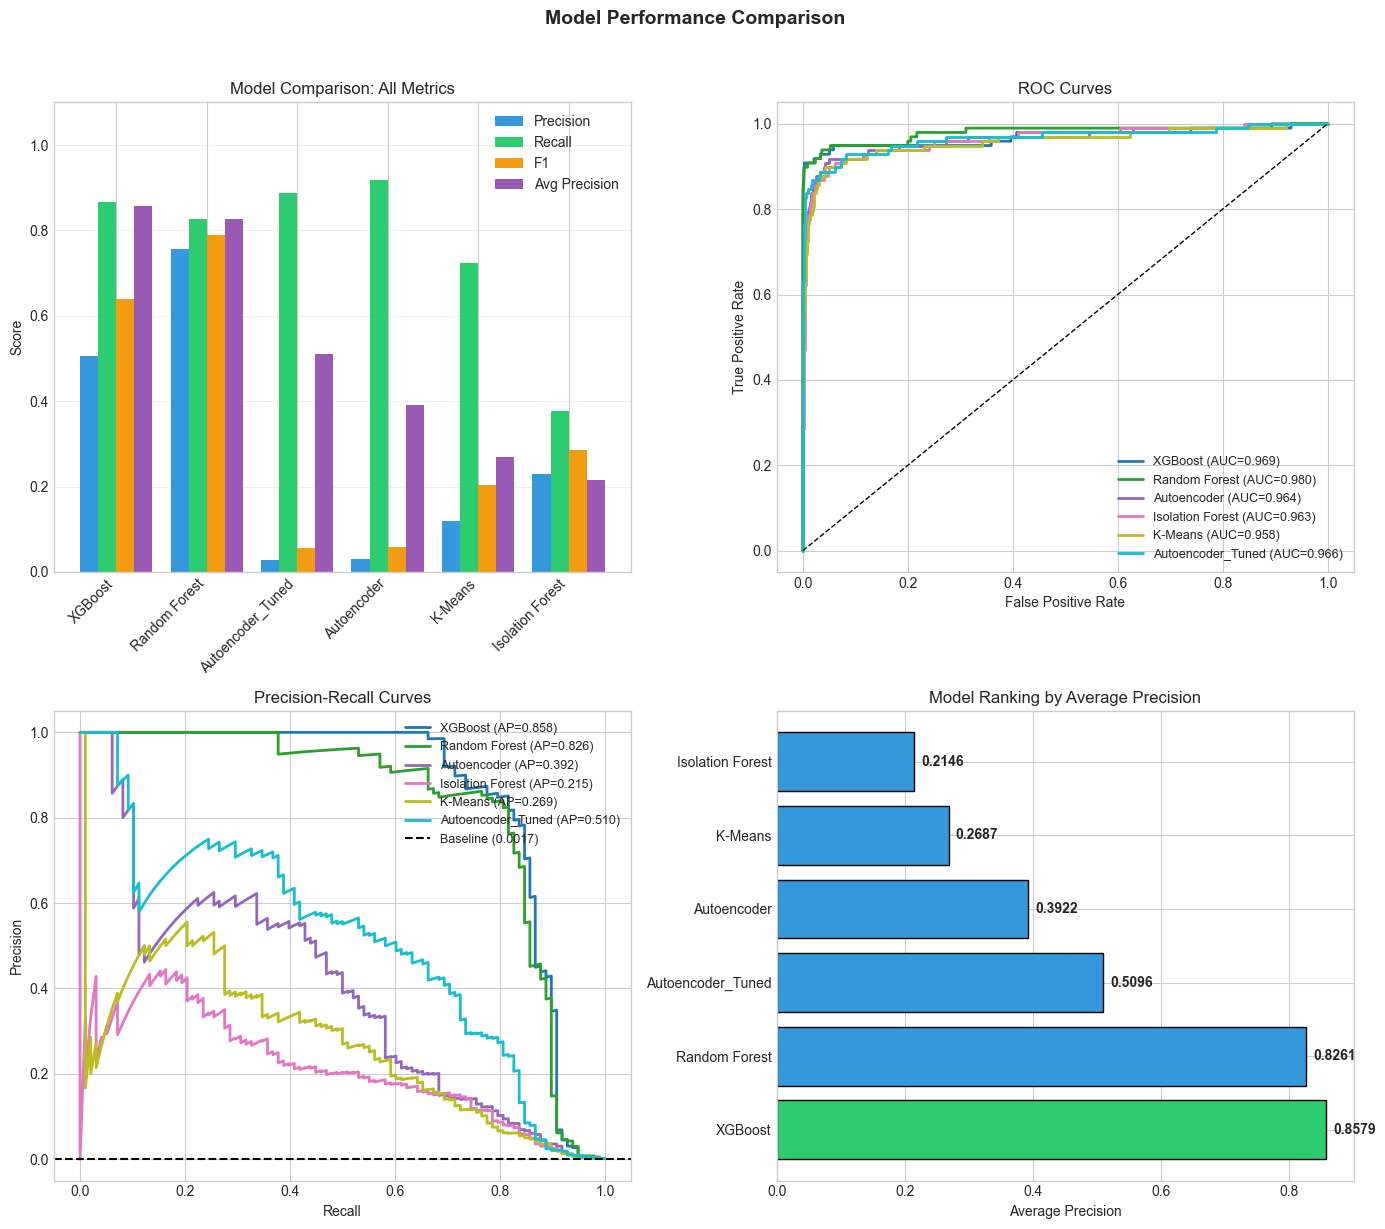

In [56]:
# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Metric comparison
ax = axes[0, 0]
x = np.arange(len(results_df))
width = 0.2
metrics = ['precision', 'recall', 'f1', 'avg_precision']
colors = ['#3498db', '#2ecc71', '#f39c12', '#9b59b6']

for i, (metric, color) in enumerate(zip(metrics, colors)):
    offset = width * (i - 1.5)
    ax.bar(x + offset, results_df[metric], width, label=metric.replace('_', ' ').title(), color=color)

ax.set_ylabel('Score')
ax.set_title('Model Comparison: All Metrics')
ax.set_xticks(x)
ax.set_xticklabels(results_df.index, rotation=45, ha='right')
ax.legend()
ax.set_ylim(0, 1.1)
ax.grid(True, alpha=0.3, axis='y')

# ROC Curves
ax = axes[0, 1]
colors = plt.cm.tab10(np.linspace(0, 1, len(all_probabilities)))
for (name, proba), color in zip(all_probabilities.items(), colors):
    fpr, tpr, _ = roc_curve(y_test, proba)
    auc_score = roc_auc_score(y_test, proba)
    ax.plot(fpr, tpr, color=color, lw=2, label=f'{name} (AUC={auc_score:.3f})')
ax.plot([0, 1], [0, 1], 'k--', lw=1)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves')
ax.legend(loc='lower right', fontsize=9)

# PR Curves
ax = axes[1, 0]
for (name, proba), color in zip(all_probabilities.items(), colors):
    precision, recall, _ = precision_recall_curve(y_test, proba)
    ap = average_precision_score(y_test, proba)
    ax.plot(recall, precision, color=color, lw=2, label=f'{name} (AP={ap:.3f})')
ax.axhline(y=y_test.mean(), color='black', linestyle='--', label=f'Baseline ({y_test.mean():.4f})')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curves')
ax.legend(loc='upper right', fontsize=9)

# Average Precision Bar Chart
ax = axes[1, 1]
colors = ['#2ecc71' if x == results_df['avg_precision'].max() else '#3498db' for x in results_df['avg_precision']]
bars = ax.barh(results_df.index, results_df['avg_precision'], color=colors, edgecolor='black')
ax.set_xlabel('Average Precision')
ax.set_title('Model Ranking by Average Precision')
for bar in bars:
    width = bar.get_width()
    ax.annotate(f'{width:.4f}', xy=(width, bar.get_y() + bar.get_height()/2),
                xytext=(5, 0), textcoords='offset points', ha='left', va='center', fontweight='bold')

plt.suptitle('Model Performance Comparison', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
print("\n" + "="*70)
print("CONCLUSIONS")
print("="*70)

best_model = results_df['avg_precision'].idxmax()
best_ap = results_df['avg_precision'].max()

print(f"""
BEST MODEL: {best_model}
Average Precision: {best_ap:.4f}

KEY FINDINGS:

1. Supervised models (XGBoost, Random Forest) outperform unsupervised approaches
   when labeled data is available.

2. Autoencoder provides a middle-ground approach:
   - Good recall (catches most fraud)
   - Can detect novel fraud patterns not in training data
   - Useful when labeled data is scarce

3. Pure unsupervised methods (Isolation Forest, K-Means) have lower precision
   but can detect unusual patterns without labels.

4. The comprehensive EDA guided our feature engineering:
   - V14, V12, V10 identified as most discriminative
   - Time-based features capture temporal patterns
   - Log transformation improves Amount distribution

RECOMMENDATIONS:

1. Production: Use XGBoost as primary model (best precision-recall trade-off)
2. Hybrid approach: Combine with Autoencoder to catch novel fraud patterns
3. Monitoring: Continuously track model performance and retrain regularly
4. Threshold tuning: Adjust based on business cost of false positives vs missed fraud
""")


CONCLUSIONS

BEST MODEL: XGBoost
Average Precision: 0.8579

KEY FINDINGS:

1. Supervised models (XGBoost, Random Forest) outperform unsupervised approaches
   when labeled data is available.

2. Autoencoder provides a middle-ground approach:
   - Good recall (catches most fraud)
   - Can detect novel fraud patterns not in training data
   - Useful when labeled data is scarce

3. Pure unsupervised methods (Isolation Forest, K-Means) have lower precision
   but can detect unusual patterns without labels.

4. The comprehensive EDA guided our feature engineering:
   - V14, V12, V10 identified as most discriminative
   - Time-based features capture temporal patterns
   - Log transformation improves Amount distribution

RECOMMENDATIONS:

1. Production: Use XGBoost as primary model (best precision-recall trade-off)
2. Hybrid approach: Combine with Autoencoder to catch novel fraud patterns
3. Monitoring: Continuously track model performance and retrain regularly
4. Threshold tuning: Adjust ba